In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp /content/gdrive/MyDrive/PhD/Knutdata-20221206T074655Z-001.zip Knutdata.zip

In [3]:
!unzip Knutdata.zip

Archive:  Knutdata.zip
  inflating: Knutdata/B11.1_H5.4_frame_000001_Nz100.tif  
  inflating: Knutdata/B12.1_A1.5_frame_000001_Nz93(1).tif  
  inflating: Knutdata/B11.1_H5.4_frame_000001_Nz100(1).tif  
  inflating: Knutdata/B12.1_A1.5_frame_000001_Nz93.tif  


In [4]:
import tifffile
im = tifffile.imread('Knutdata/B11.1_H5.4_frame_000001_Nz100.tif', maxworkers=6)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tifffile

# red tif
im = tifffile.imread('Knutdata/B11.1_H5.4_frame_000001_Nz100.tif', maxworkers=6)

# remove empty slices + crop empty spaces
im = im[:192,256:-256,256:-256] # <--------------------------------------------- im is ground truth
im = im.astype(np.float64)
im = np.expand_dims(im, axis=0)

im = (im - np.min(im))/(np.max(im) - np.min(im))

print('final shape: {}'.format(im.shape))

final shape: (1, 192, 512, 512)


In [6]:
import math
from numpy import log

def Gauss(sigma):
    sigma = np.array(sigma,dtype = 'float32')
    s=sigma.size
    if s==1:
       sigma=[sigma,sigma]
    sigma = np.array(sigma,dtype = 'float32')
    psfN = np.ceil(sigma / math.sqrt(8 * log(2)) * math.sqrt(-2 * log(0.0002))) + 1
    N = psfN * 2 + 1
    sigma = sigma / (2 * math.sqrt(2 * log(2)))
    dim = len(N)
    if dim > 1:
        N[1] = np.maximum(N[0], N[1])
        N[0] = N[1]
    if dim == 2:
        m = N[0]
        n = N[1]
        x = np.arange(-np.fix((n / 2)), np.ceil((n / 2)),dtype='float32')
        y = np.arange(-np.fix((m / 2)), np.ceil((m / 2)),dtype='float32')
        X, Y = np.meshgrid(x, y)
        s1 = sigma[0]
        s2 = sigma[1]
        PSF = np.exp(-(X * X) / (2 * np.dot(s1, s1)) - (Y * Y) / (2 * np.dot(s2, s2)))
        PSFsum = PSF.sum()
        PSF = PSF / PSFsum
        center = [m / 2 + 1, n / 2 + 1]
        return PSF

In [7]:
from scipy.ndimage import convolve

k = Gauss(4.)
k = np.expand_dims(k, axis=0)
k = np.expand_dims(k, axis=0)
im_conv = convolve(im, k)  # <-------------------------------------------------- im_conv is the input to RLN

In [8]:
from PIL import Image

# add center haze
pp = Gauss(20.)
pp = pp[20:-20,20:-20]
pp = np.array(Image.fromarray(pp).resize((512,512)))
pp = (pp - np.min(pp))/(np.max(pp) - np.min(pp))

pp = np.expand_dims(pp, axis=0)
pp = np.tile(pp,(192,1,1))

In [9]:
im_conv_noise = im_conv + pp*1.5 + np.random.poisson(1, pp.shape)*0.3

In [10]:
im_conv_noise = (im_conv_noise - np.min(im_conv_noise))/(np.max(im_conv_noise) - np.min(im_conv_noise))

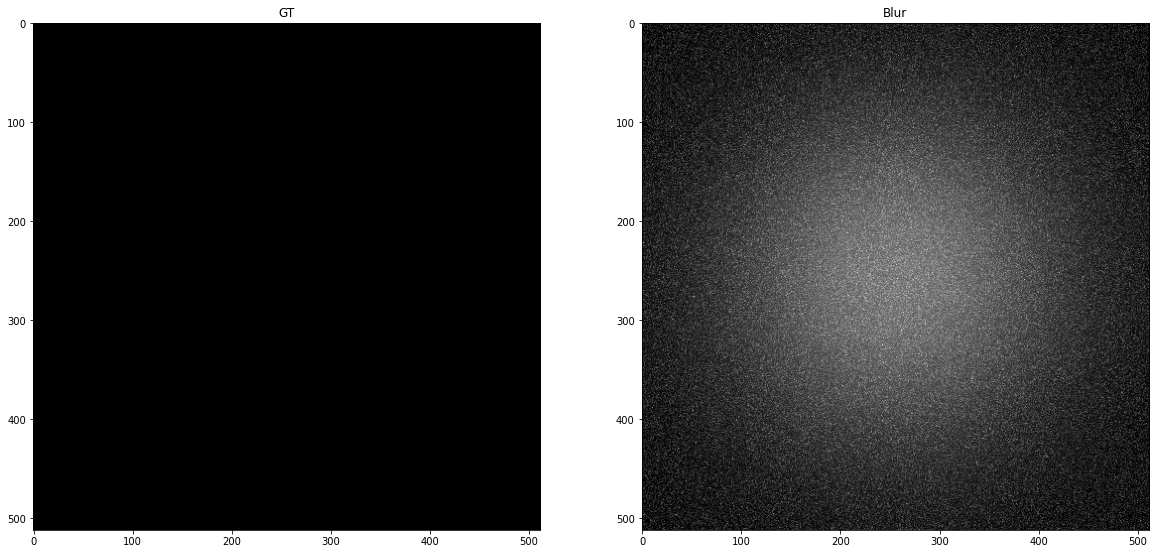

In [11]:
index = np.random.randint(0,im_conv_noise.shape[1])

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(im[0,index], cmap='gray')
plt.title('GT')
plt.subplot(1,2,2)
plt.imshow(im_conv_noise[0,index], cmap='gray')
plt.title('Blur')
plt.show()

In [12]:
def get_SSIM(gt, pred):
    mean_pred = torch.mean(pred)
    mean_gt = torch.mean(gt)
    sigma_pred = torch.mean(torch.square(pred - mean_pred))
    sigma_gt = torch.mean(torch.square(gt - mean_gt))
    sigma_cross = torch.mean((pred - mean_pred) * (gt - mean_gt))

    SSIM_1 = 2 * mean_pred * mean_gt + 1e-4
    SSIM_2 = 2 * sigma_cross + 9e-4
    SSIM_3 = torch.square(mean_pred) + torch.square(mean_gt) + 1e-4
    SSIM_4 = sigma_pred + sigma_gt + 9e-4
    SSIM = (SSIM_1*SSIM_2)/(SSIM_3*SSIM_4)

    return SSIM

In [13]:
from torch.utils import data

# NCDHW
# assumption is to use 8x64x64 (DHW) slices to train
# the input z-stacks are 96x512x512 (DWH)

# 144x512x512
# 48x512x512

class ImageLoader(data.Dataset):
    def __init__(self, gt, blur, test=False):
        self.gt = gt
        self.blur = blur

        if test:
            self.len = 18 * 8 * 8
        else:
            self.len = 6 * 8 * 8

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        z = index // 64 # depth selector
        
        t = index - 64*z
        x = t//8
        y = t%8

        blur = self.blur[:,z*8:(z+1)*8,x*64:(x+1)*64,y*64:(y+1)*64]
        gt = self.gt[:,z*8:(z+1)*8,x*64:(x+1)*64,y*64:(y+1)*64]

        return blur, gt

In [14]:
import torch
from torch import nn
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def softplus(x):
    # return torch.log(torch.exp(x) + 1)
    return nn.ReLU()(x)

class RLN(nn.Module):
    def __init__(self):
        super(RLN, self).__init__()


        # h1 branch
        self.h1_avg_pool = torch.nn.AvgPool3d([2,2,2], stride=[2,2,2])
        self.h1_conv1 = torch.nn.Conv3d(in_channels=2, out_channels=4, kernel_size=[3,3,3], stride=[1,1,1], padding='same', bias=False)
        self.h1_bn1 = torch.nn.BatchNorm3d(4)
        self.h1_conv2 = torch.nn.Conv3d(in_channels=4, out_channels=4, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h1_bn2 = torch.nn.BatchNorm3d(4)
        self.h1_conv3 = torch.nn.Conv3d(in_channels=8, out_channels=4, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h1_bn3 = torch.nn.BatchNorm3d(4)

        self.h1_bnA = torch.nn.BatchNorm3d(2)
        
        self.h1_conv4 = torch.nn.Conv3d(in_channels=2, out_channels=8, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h1_bn4 = torch.nn.BatchNorm3d(8)
        self.h1_conv5 = torch.nn.Conv3d(in_channels=8, out_channels=8, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h1_bn5 = torch.nn.BatchNorm3d(8)
        self.h1_conv6 = torch.nn.Conv3d(in_channels=16, out_channels=8, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h1_bn6 = torch.nn.BatchNorm3d(8)

        self.h1_convup = torch.nn.ConvTranspose3d(in_channels=8, out_channels=4, kernel_size=[2,2,2], stride=[2,2,2])
        self.h1_bnB = torch.nn.BatchNorm3d(4)
        
        self.h1_conv7 = torch.nn.Conv3d(in_channels=4, out_channels=4, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h1_bn7 = torch.nn.BatchNorm3d(4)

        self.h1_bnC = torch.nn.BatchNorm3d(1)


        # h2 branch
        self.h2_conv1 = torch.nn.Conv3d(in_channels=2, out_channels=4, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h2_bn1 = torch.nn.BatchNorm3d(4)
        self.h2_conv2 = torch.nn.Conv3d(in_channels=4, out_channels=4, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h2_bn2 = torch.nn.BatchNorm3d(4)
        
        self.h2_bnA = torch.nn.BatchNorm3d(2)

        self.h2_conv3 = torch.nn.Conv3d(in_channels=2, out_channels=8, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h2_bn3 = torch.nn.BatchNorm3d(8)
        self.h2_conv4 = torch.nn.Conv3d(in_channels=8, out_channels=8, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h2_bn4 = torch.nn.BatchNorm3d(8)

        self.h2_bnB = torch.nn.BatchNorm3d(1)


        # h3 branch
        self.h3_conv1 = torch.nn.Conv3d(in_channels=1, out_channels=8, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h3_conv2 = torch.nn.Conv3d(in_channels=10, out_channels=8, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h3_conv3 = torch.nn.Conv3d(in_channels=16, out_channels=8, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h3_bnA = torch.nn.BatchNorm3d(8)

    #     self.apply(self._init_weights)

    # def _init_weights(self, module):
    #     if isinstance(module, nn.Linear):
    #         module.weight.data.normal_(mean=0.0, std=1.0)
    #         if module.bias is not None:
    #             module.bias.data.zero_()

    def forward(self, y):

        def check(x, n):
            if torch.sum(torch.isnan(x)) > 0: 
                print(n, torch.sum(torch.isnan(x)))

        yy = torch.cat([y,y],1)

        # ******** h1 branch ********
        x = self.h1_avg_pool(yy)

        xt = softplus(torch.cat([x,x], 1))

        # =============================================
        # this creates nan

        # FP1
        check(x, 'A')
        x1 = self.h1_conv1(x)
        check(x1, 'B')
        x1 = self.h1_bn1(x1)
        check(x1, 'C')
        x1 = softplus(x1)
        check(x1, 'D')

        check(x1, 1)

        # =============================================

        x2 = self.h1_conv2(x1)
        x2 = self.h1_bn2(x2)
        x2 = softplus(x2)

        check(x2, 2)

        xx = torch.cat([x1,x2], 1)

        x3 = self.h1_conv3(xx)
        x3 = self.h1_bn3(x3)
        x3 = softplus(x3) + xt

        check(x3, 3)

        # C_AVE
        xy = torch.mean(x3, dim=1, keepdim=True)
        xy = torch.cat([xy,xy], 1)

        # DV1
        xy = (x)/(xy + 0.001)
        xy = self.h1_bnA(xy)

        check(xy, 33)

        # BP1
        x4 = self.h1_conv4(xy)
        x4 = self.h1_bn4(x4)
        x4 = softplus(x4)

        check(x4, 4)

        x5 = self.h1_conv5(x4)
        x5 = self.h1_bn5(x5)
        x5 = softplus(x5)

        check(x5, 5)

        xx = torch.cat([x4,x5], 1)

        x6 = self.h1_conv6(xx)
        x6 = self.h1_bn6(x6)
        x6 = softplus(x6)

        check(x6, 6)

        # BP1_up
        xu = self.h1_convup(x6)
        xu = self.h1_bnB(xu)
        xu = softplus(xu)

        check(xu, 66)

        x7 = self.h1_conv7(xu)
        x7 = self.h1_bn7(x7)
        x7 = softplus(x7)

        check(x7, 7)

        # C_AVE
        xz = torch.mean(x7, dim=1, keepdim=True)        

        # E1
        temp = xz * y # <--- use for loss

        xq = self.h1_bnC(temp)
        e1 = softplus(xq)

        check(e1, 77)

        # ******** h2 branch ********
        # FP2
        y1 = self.h2_conv1(yy)
        y1 = self.h2_bn1(y1)
        y1 = softplus(y1)

        y2 = self.h2_conv2(y1)
        y2 = self.h2_bn2(y2)
        y2 = softplus(y2)

        # C_AVE
        yq = torch.mean(y2, dim=1, keepdim=True)
        yq = torch.cat([yq,yq], 1)

        # DV2
        yq = (yy)/(yq + 0.001)
        yq = self.h2_bnA(yq)
        
        # BP2
        y3 = self.h2_conv3(yq)
        y3 = self.h2_bn3(y3)
        y3 = softplus(y3)

        y4 = self.h2_conv4(y3)
        y4 = self.h2_bn4(y4)
        y4 = softplus(y4) + torch.ones(y4.shape).to(device)

        # E2
        yz = torch.mean(y4, dim=1, keepdim=True)

        yz = e1 * yz
        yz = self.h2_bnB(yz)
        e2 = softplus(yz)

        # ******** h3 branch ********
        z1 = self.h3_conv1(e2)
        z1 = softplus(z1)
        zz1 = torch.cat([z1,e2,e1], 1)

        z2 = self.h3_conv2(zz1)
        z2 = softplus(z2)

        m = torch.cat([z1,z2], 1)
        z3 = self.h3_conv3(m)
        z3 = self.h3_bnA(z3)
        z3 = softplus(z3)

        ef = torch.mean(z3, dim=1, keepdim=True)

        return ef, temp

In [15]:
from torch.utils.data import DataLoader

train_gt_data = torch.from_numpy(im[:,:144,:,:])
train_blur_data = torch.from_numpy(im_conv_noise[:,:144,:,:])

val_gt_data = torch.from_numpy(im[:,144:,:,:])
val_blur_data = torch.from_numpy(im_conv_noise[:,144:,:,:])

rln_train = ImageLoader(train_gt_data, train_blur_data)
rln_train_dataloader = DataLoader(rln_train, batch_size=4, shuffle=True)

rln_val = ImageLoader(val_gt_data, val_blur_data)
rln_val_dataloader = DataLoader(rln_val, batch_size=1, shuffle=True)

In [16]:
net = RLN().to(device)

opt = torch.optim.NAdam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
mse_loss = nn.MSELoss()

 -- Staring training epoch 1 --
train loss: 0.32190985470568684
validation loss: 0.17280937451851006


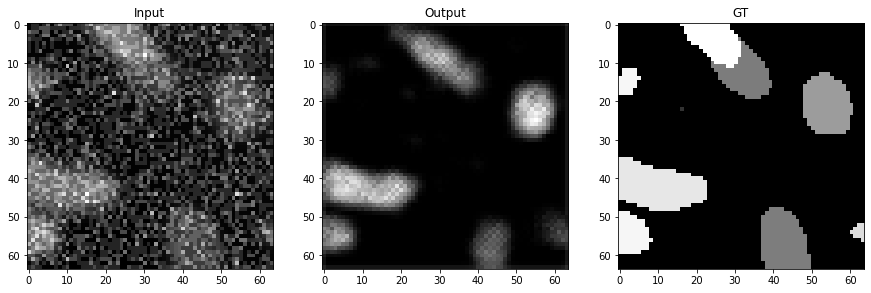

 -- Staring training epoch 2 --
train loss: 0.1918586389350788
validation loss: 0.15901401792033543


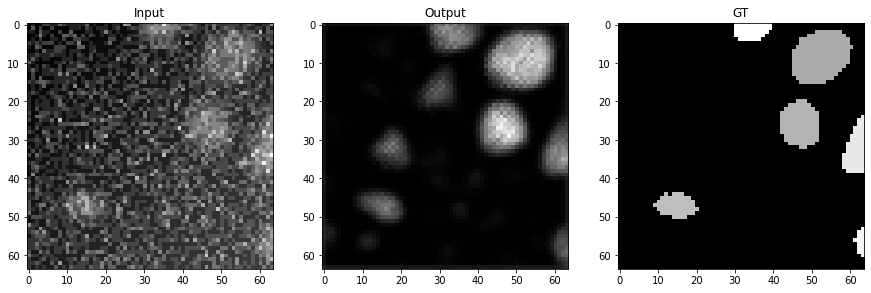

 -- Staring training epoch 3 --
train loss: 0.17335695083528416
validation loss: 0.1370804372208754


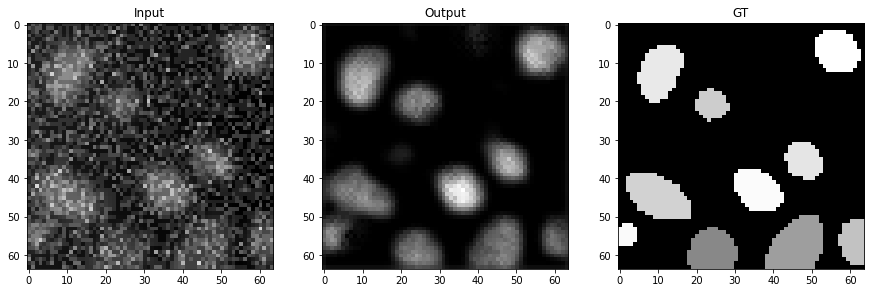

 -- Staring training epoch 4 --
train loss: 0.15501276914940174
validation loss: 0.47848727719700196


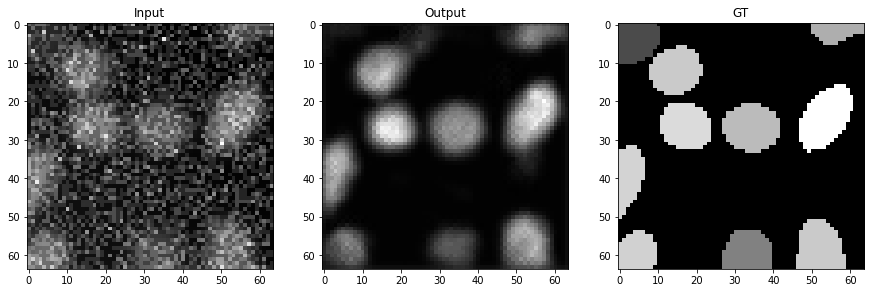

 -- Staring training epoch 5 --
train loss: 0.1622196115659906
validation loss: 0.1294951710934669


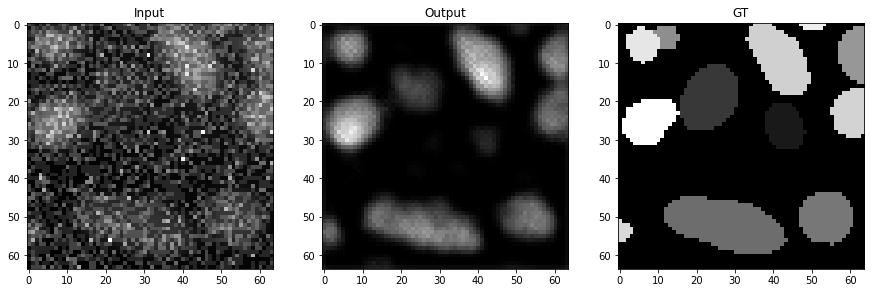

 -- Staring training epoch 6 --
train loss: 0.13486952071558045
validation loss: 0.11937790133929095


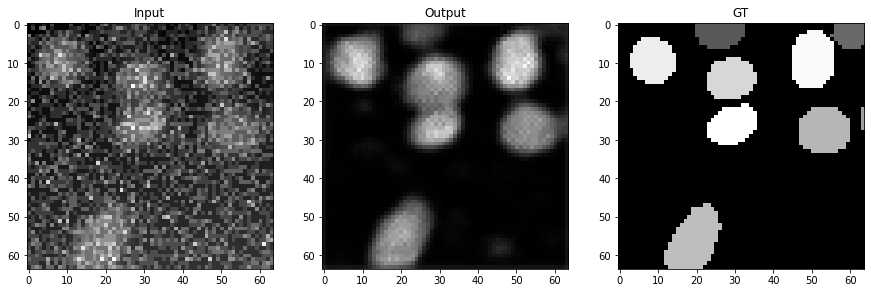

 -- Staring training epoch 7 --
train loss: 0.13532713310015265
validation loss: 0.1146814351979979


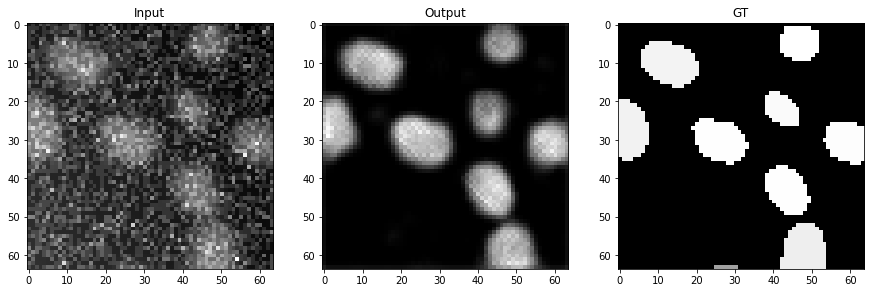

 -- Staring training epoch 8 --
train loss: 0.13710813116000214
validation loss: 0.0975544103605996


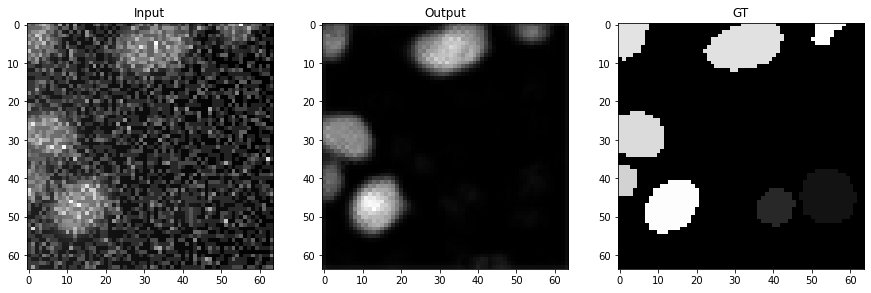

 -- Staring training epoch 9 --
train loss: 0.13463154464531826
validation loss: 0.10141264636203662


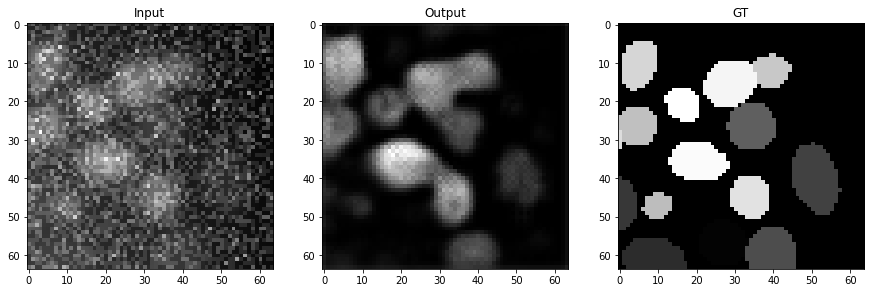

 -- Staring training epoch 10 --
train loss: 0.11394394630672133
validation loss: 0.10819021573285247


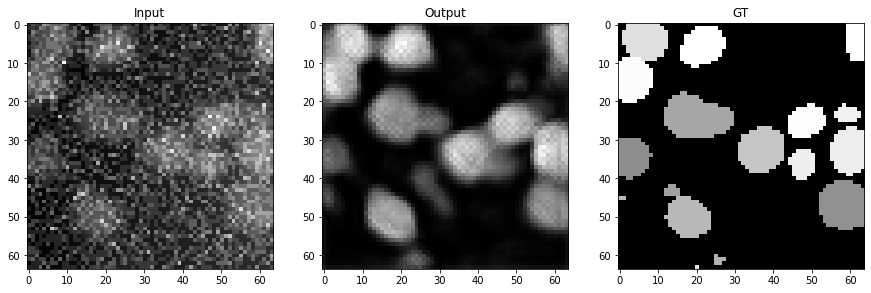

 -- Staring training epoch 11 --
train loss: 0.1205215872851902
validation loss: 0.1770854320461639


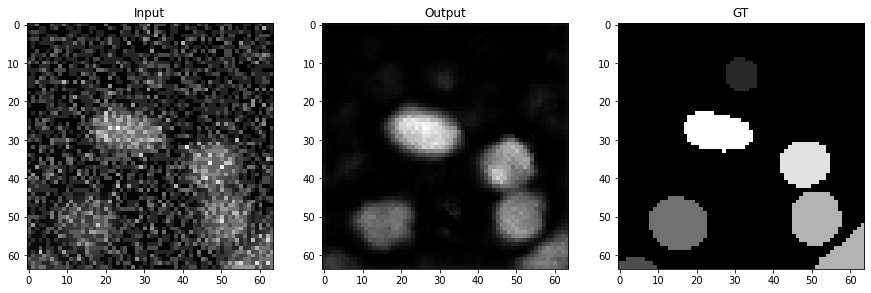

 -- Staring training epoch 12 --
train loss: 0.11733765086091164
validation loss: 0.11412774488987554


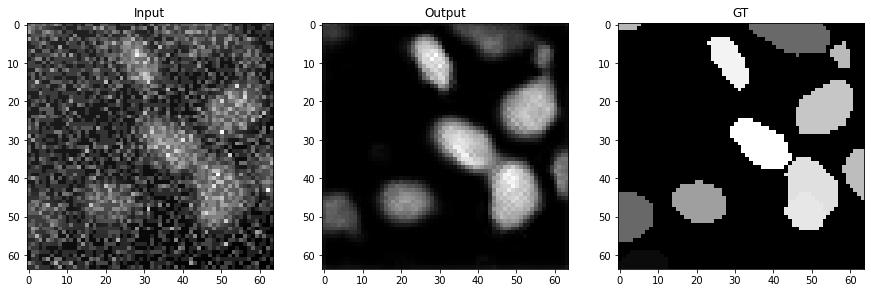

 -- Staring training epoch 13 --
train loss: 0.12291375234431186
validation loss: 0.11342005013673935


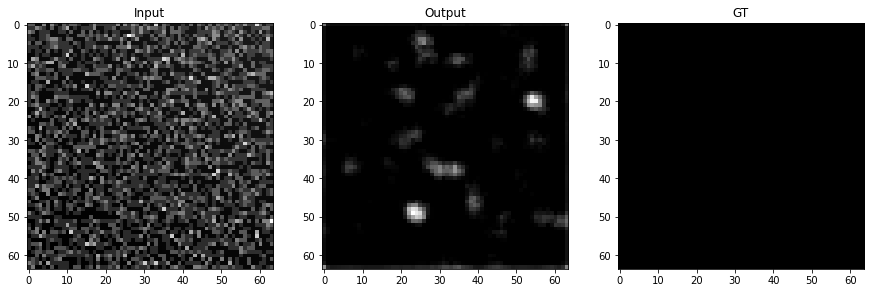

 -- Staring training epoch 14 --
train loss: 0.12068409440301724
validation loss: 0.10108720820798145


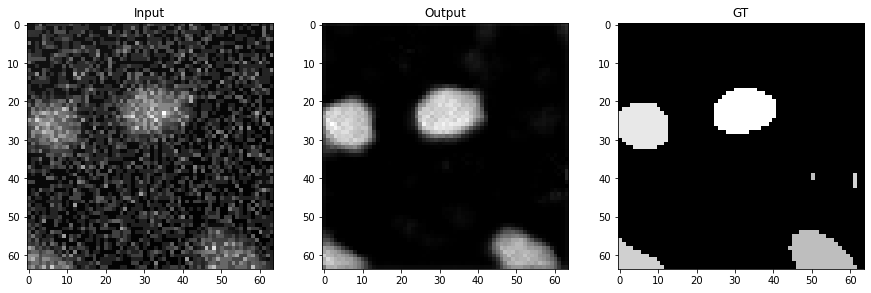

 -- Staring training epoch 15 --
train loss: 0.12057231054017924
validation loss: 0.13372956905671293


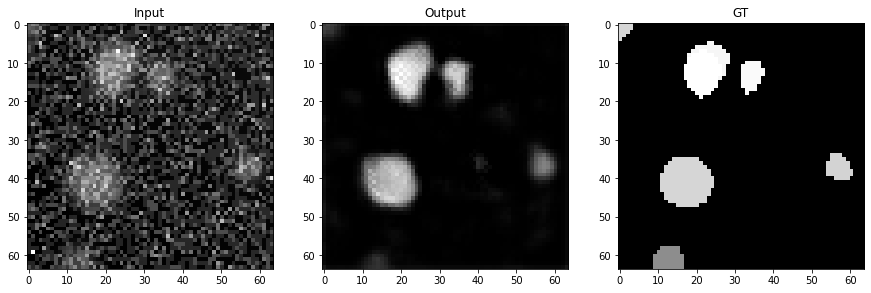

 -- Staring training epoch 16 --
train loss: 0.09912326025583683
validation loss: 0.07955219725510687


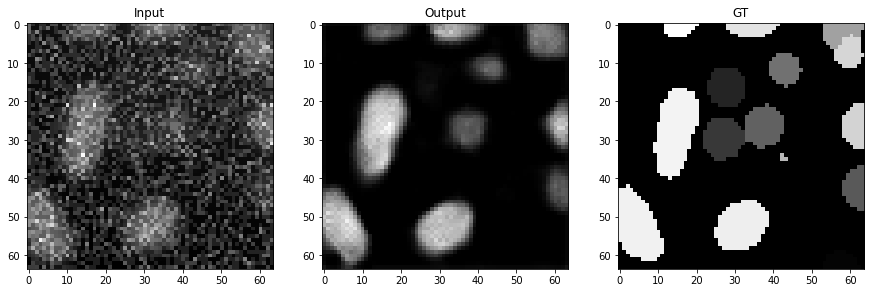

 -- Staring training epoch 17 --
train loss: 0.10466162481128531
validation loss: 0.11589685286166977


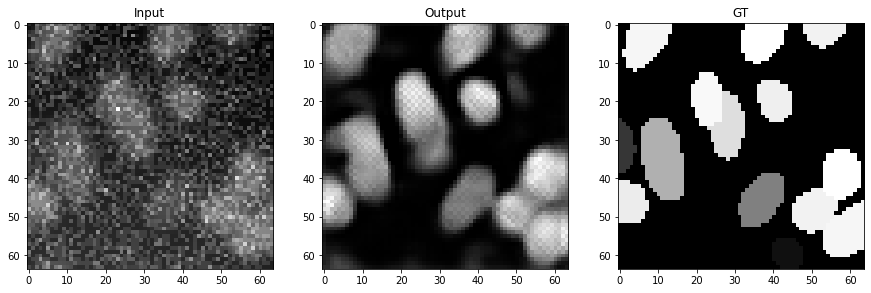

 -- Staring training epoch 18 --
train loss: 0.10323947671466453
validation loss: 0.10327127461499967


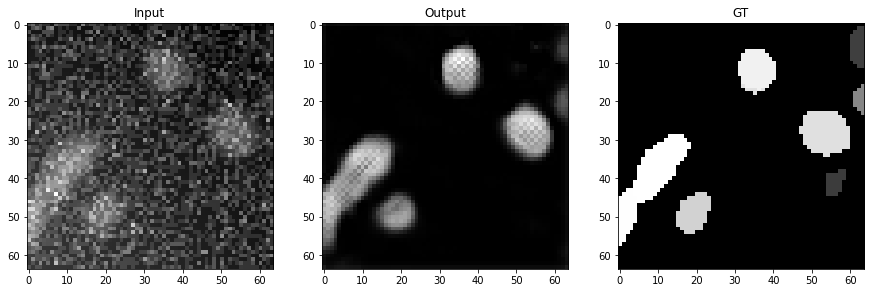

 -- Staring training epoch 19 --
train loss: 0.09717410226277982
validation loss: 0.08487971108527596


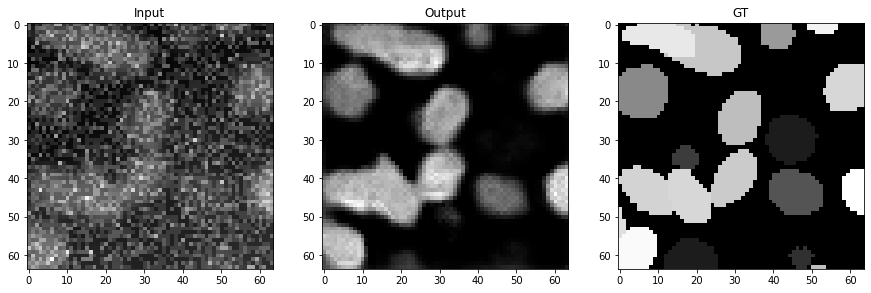

 -- Staring training epoch 20 --
train loss: 0.09512779993144106
validation loss: 0.08879701519873812


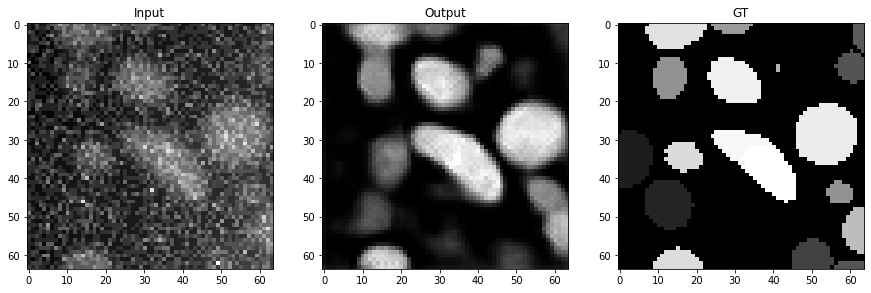

 -- Staring training epoch 21 --
train loss: 0.11829266761611536
validation loss: 0.09268044193294095


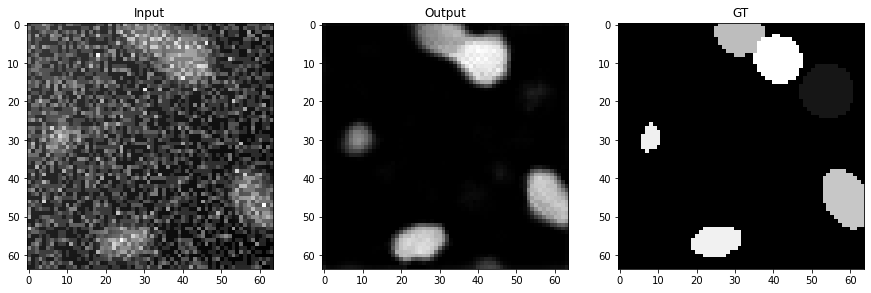

 -- Staring training epoch 22 --
train loss: 0.09754880467300762
validation loss: 0.07851568862148704


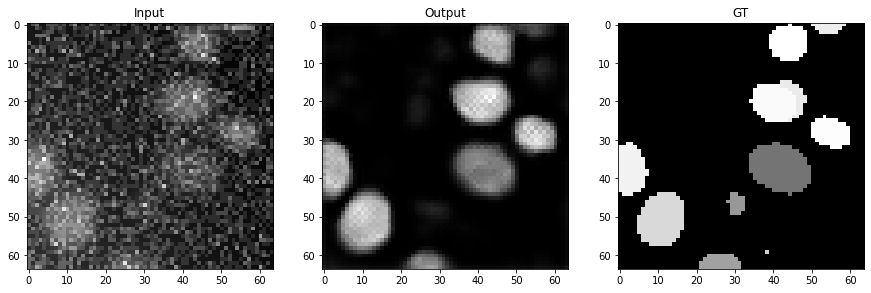

 -- Staring training epoch 23 --
train loss: 0.10074367340682693
validation loss: 0.07816361750241764


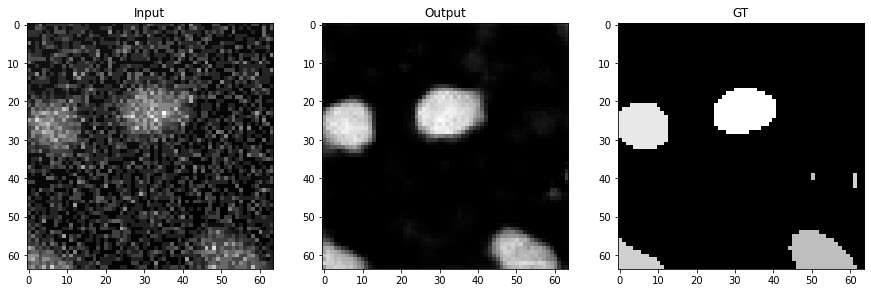

 -- Staring training epoch 24 --
train loss: 0.11073972873929842
validation loss: 0.10542245793838612


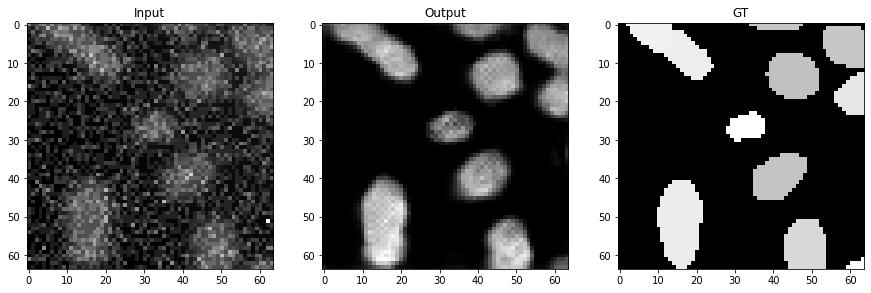

 -- Staring training epoch 25 --
train loss: 0.09979505715088972
validation loss: 0.08104208656977496


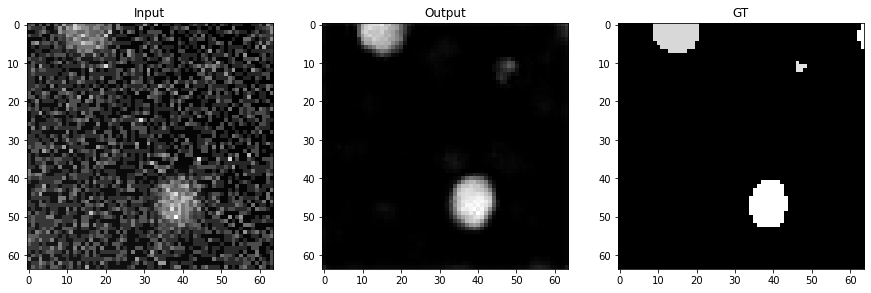

 -- Staring training epoch 26 --
train loss: 0.08815638605973929
validation loss: 0.0945767864433853


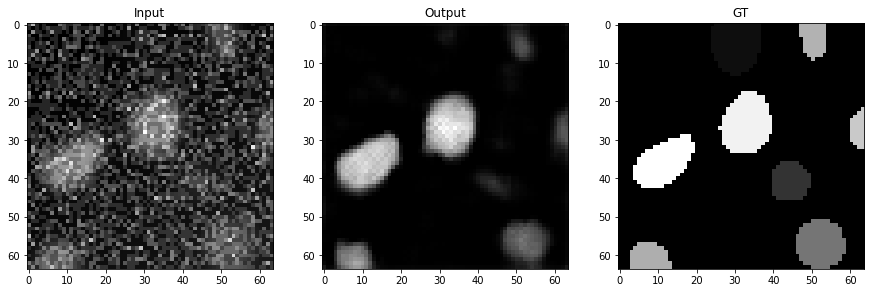

 -- Staring training epoch 27 --
train loss: 0.09691880746268573
validation loss: 0.07985718263975293


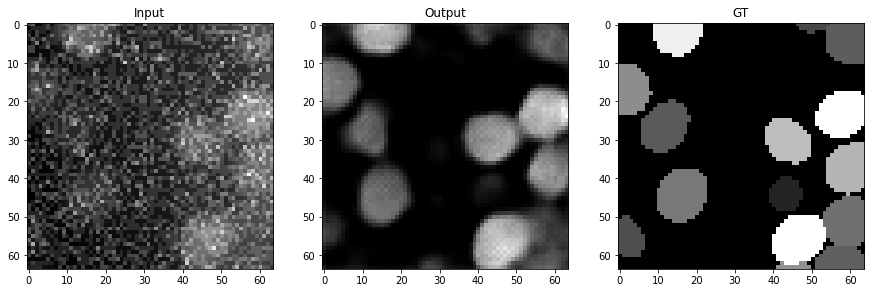

 -- Staring training epoch 28 --
train loss: 0.08507994330276351
validation loss: 0.075845491583824


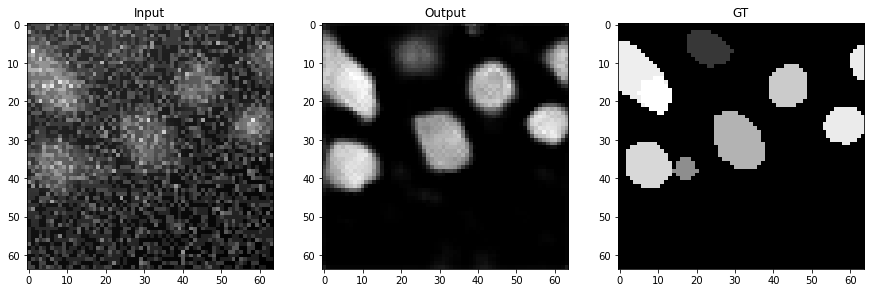

 -- Staring training epoch 29 --
train loss: 0.09337680871201837
validation loss: 0.08081664658377186


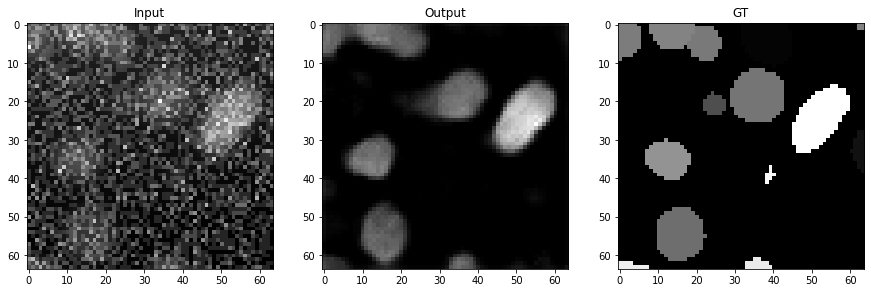

 -- Staring training epoch 30 --
train loss: 0.08858974720738877
validation loss: 0.08436740977085927


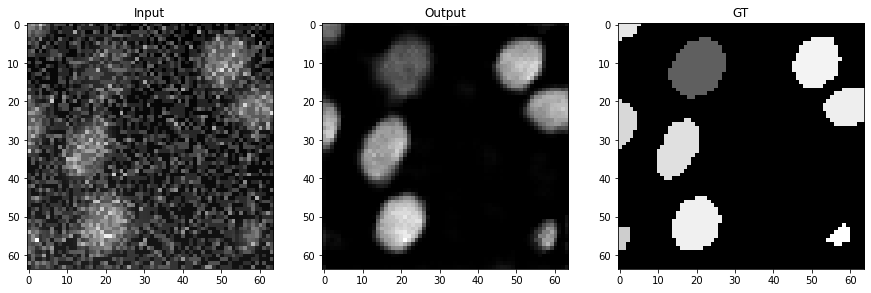

 -- Staring training epoch 31 --
train loss: 0.09386367949321262
validation loss: 0.07831225571089799


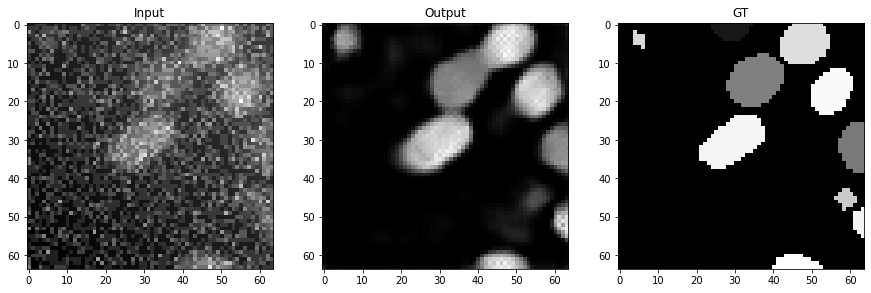

 -- Staring training epoch 32 --
train loss: 0.09760338983021684
validation loss: 0.08364601727508807


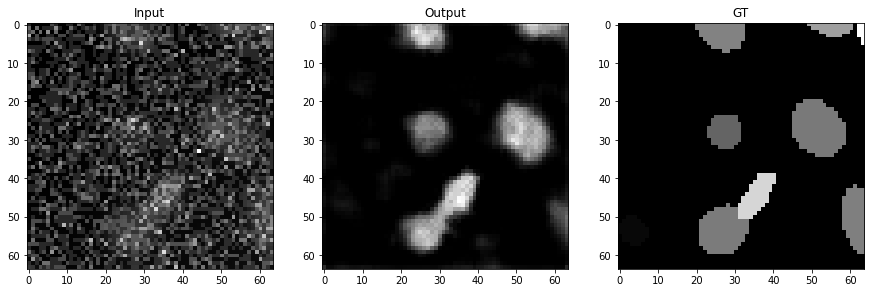

 -- Staring training epoch 33 --
train loss: 0.09005158544266346
validation loss: 0.08279554715181682


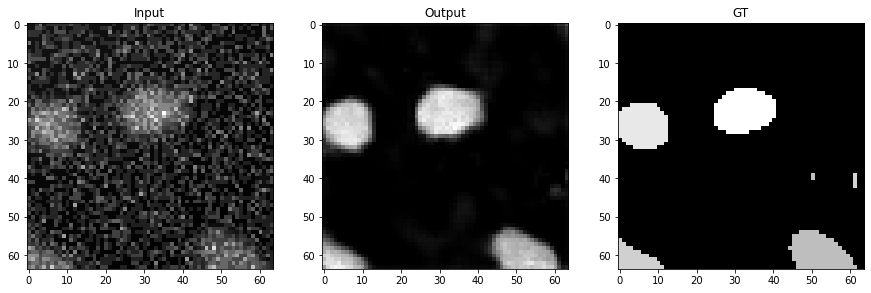

 -- Staring training epoch 34 --
train loss: 0.0853344855840301
validation loss: 0.08161257954408808


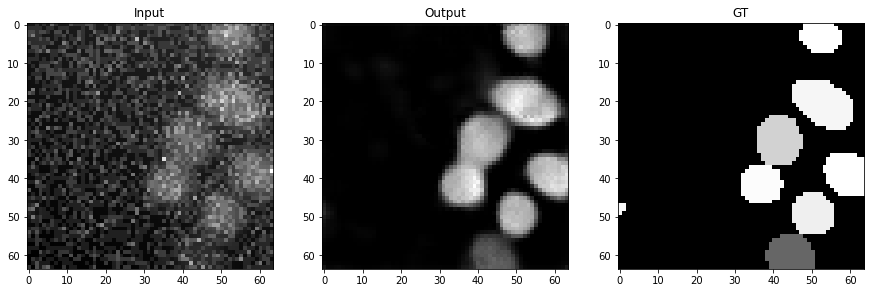

 -- Staring training epoch 35 --
train loss: 0.08198084670995323
validation loss: 0.07232007523409799


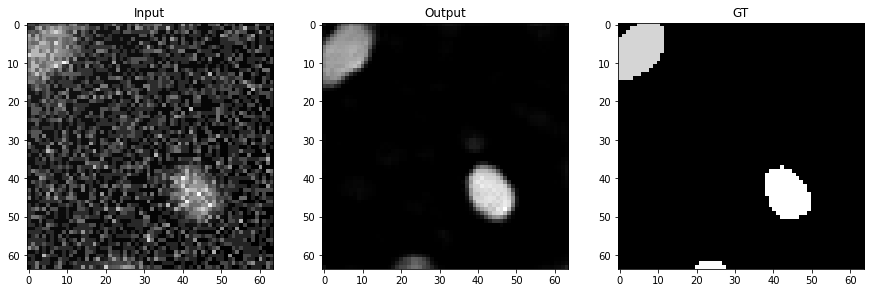

 -- Staring training epoch 36 --
train loss: 0.08419270471796096
validation loss: 0.09741035117813905


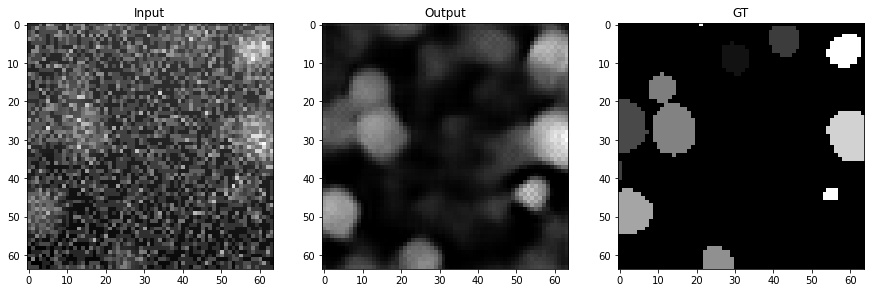

 -- Staring training epoch 37 --
train loss: 0.1370579014876031
validation loss: 0.11007188094466608


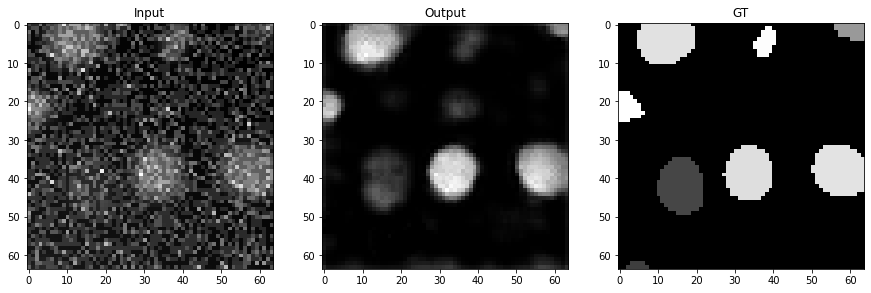

 -- Staring training epoch 38 --
train loss: 0.1007746977928398
validation loss: 0.09580937890811751


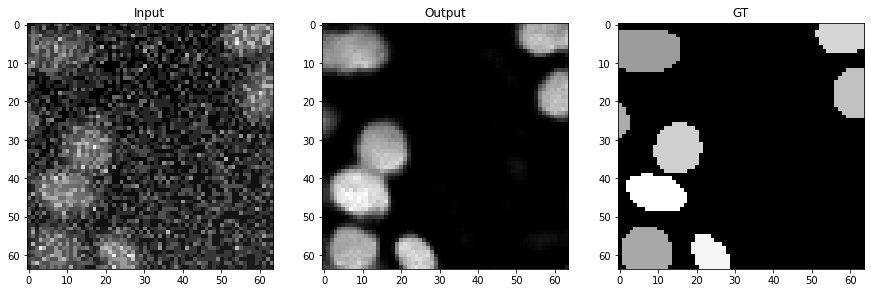

 -- Staring training epoch 39 --
train loss: 0.08954792645650307
validation loss: 0.07590012229567987


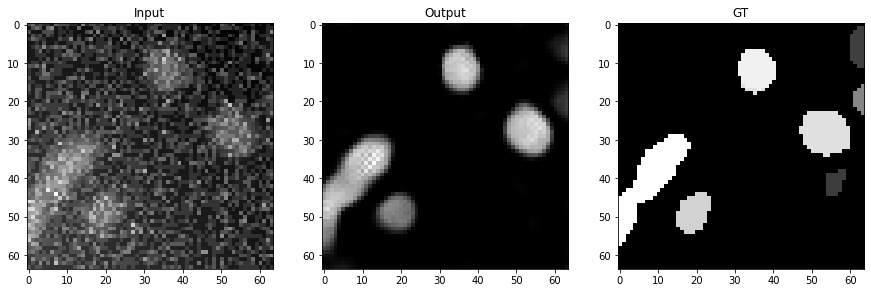

 -- Staring training epoch 40 --
train loss: 0.08609435809057332
validation loss: 0.07765125567726923


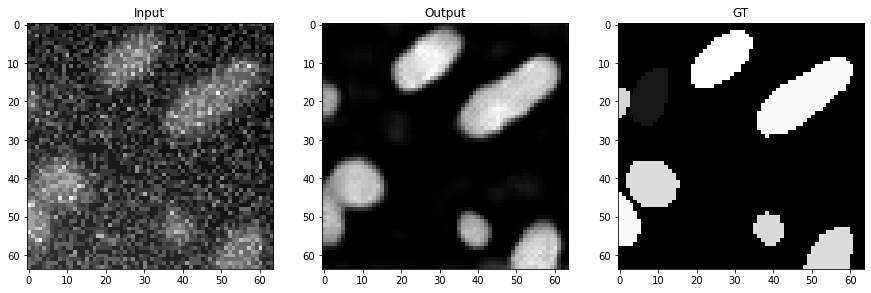

 -- Staring training epoch 41 --
train loss: 0.08079194709964346
validation loss: 0.07473476758007806


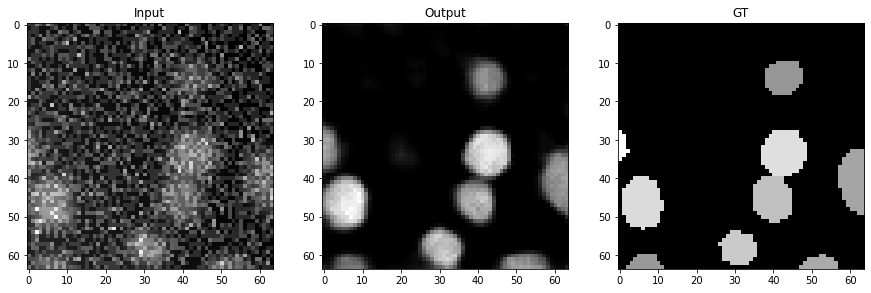

 -- Staring training epoch 42 --
train loss: 0.08188105211030934
validation loss: 0.07961909899691287


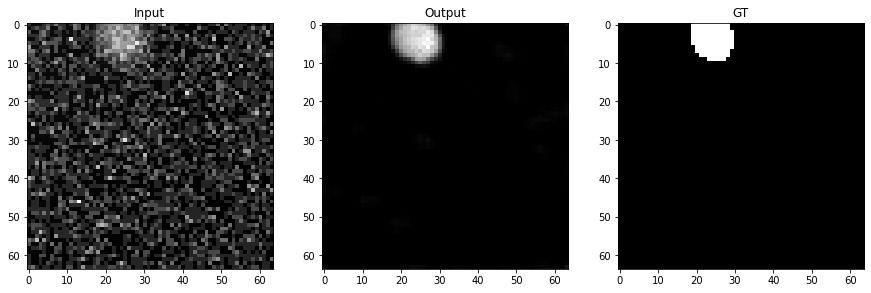

 -- Staring training epoch 43 --
train loss: 0.07908477618357397
validation loss: 0.08308199845663441


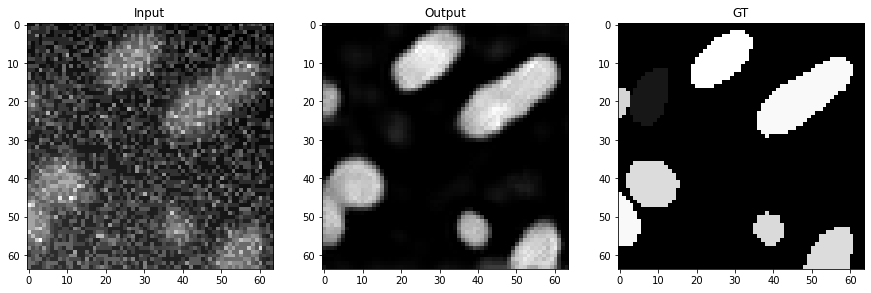

 -- Staring training epoch 44 --
train loss: 0.08724351650187216
validation loss: 0.07240263264647084


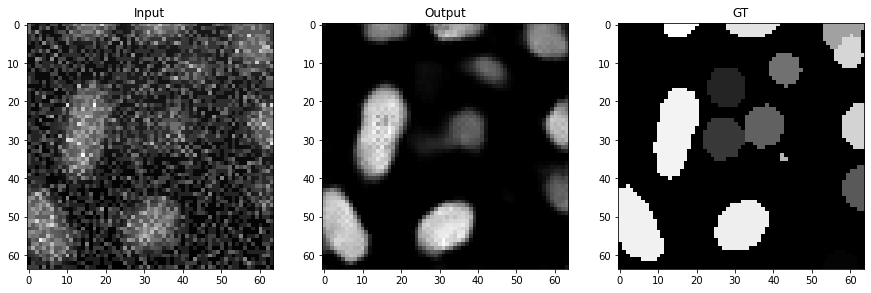

 -- Staring training epoch 45 --
train loss: 0.07886695095789685
validation loss: 0.06983992439729032


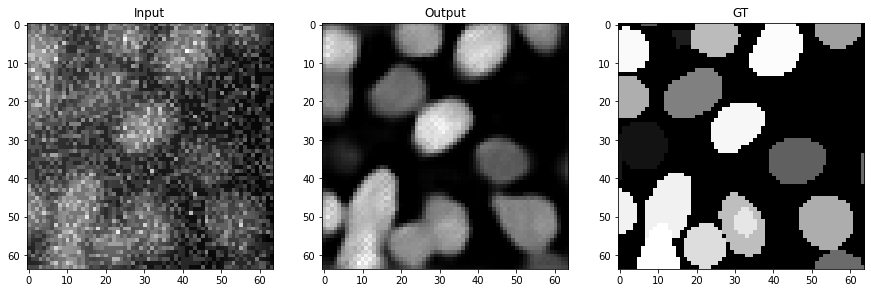

 -- Staring training epoch 46 --
train loss: 0.07930728759804939
validation loss: 0.0735259806871832


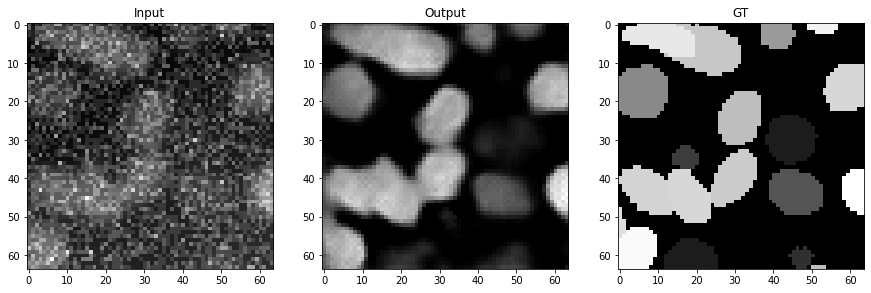

 -- Staring training epoch 47 --
train loss: 0.08126988227436453
validation loss: 0.06883927245963714


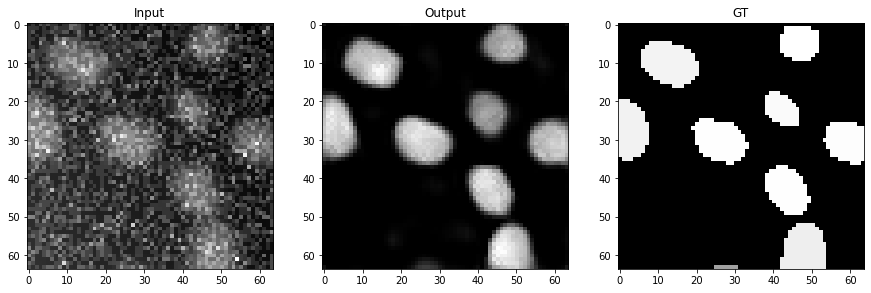

 -- Staring training epoch 48 --
train loss: 0.08940217634016845
validation loss: 0.08222962193551311


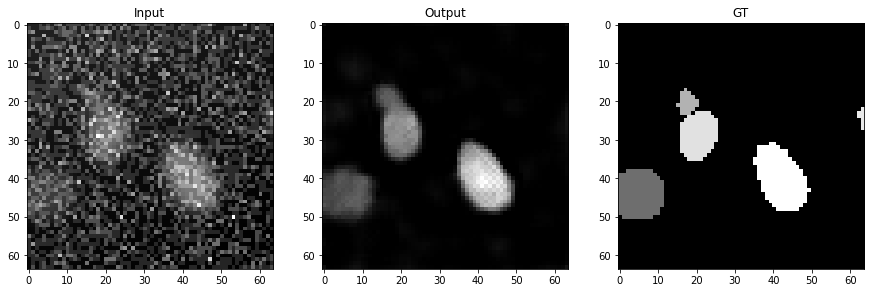

 -- Staring training epoch 49 --
train loss: 0.07878788811311131
validation loss: 0.0700122027450153


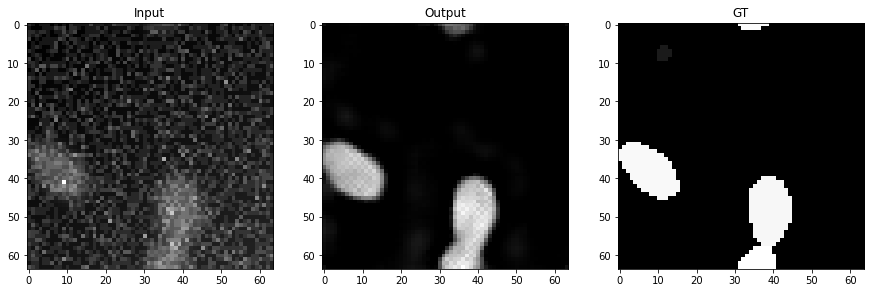

 -- Staring training epoch 50 --
train loss: 0.08237553623409472
validation loss: 0.07099171704784393


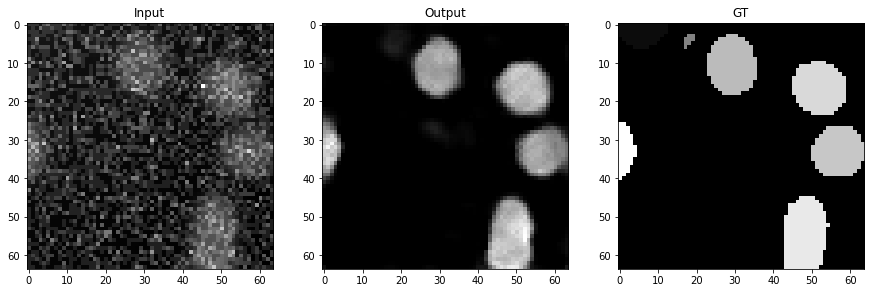

 -- Staring training epoch 51 --
train loss: 0.09514302849945457
validation loss: 0.0919761831572556


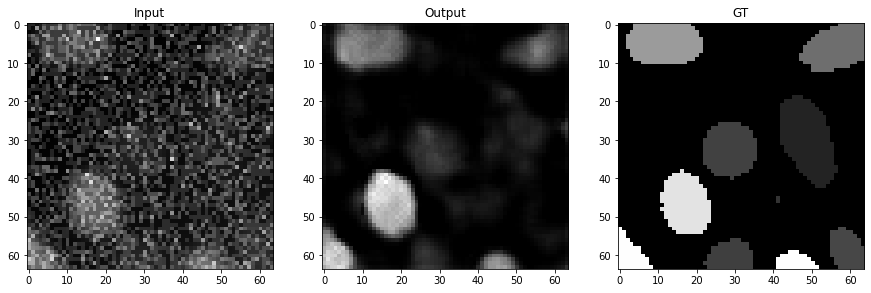

 -- Staring training epoch 52 --
train loss: 0.07858733856846678
validation loss: 0.07239729700832219


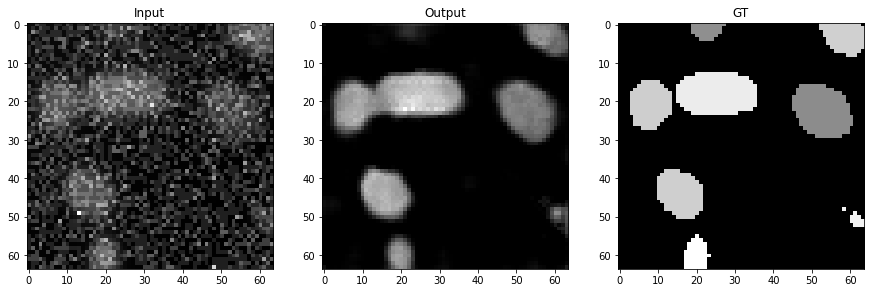

 -- Staring training epoch 53 --
train loss: 0.08757286750892357
validation loss: 0.07499979147961568


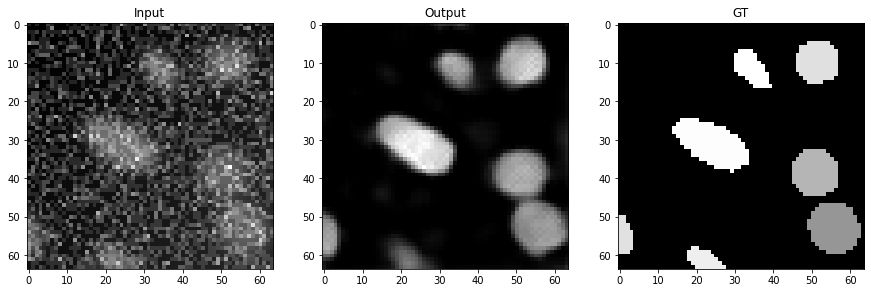

 -- Staring training epoch 54 --
train loss: 0.07703683143367007
validation loss: 0.07095411417326998


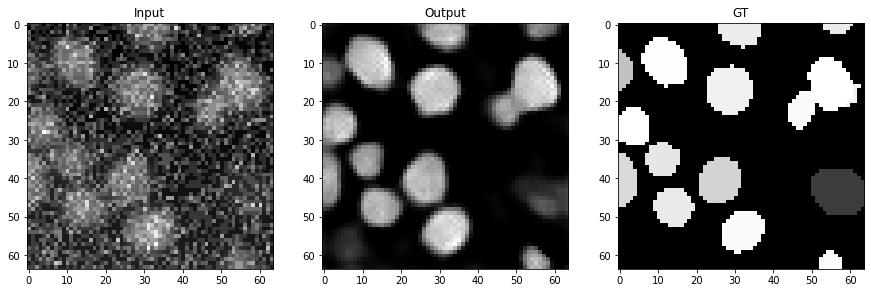

 -- Staring training epoch 55 --
train loss: 0.08152609423109723
validation loss: 0.0765927290642252


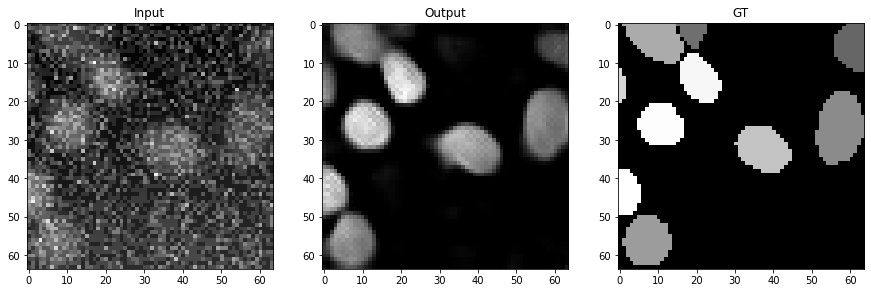

 -- Staring training epoch 56 --
train loss: 0.08105177121268517
validation loss: 0.07510467403642465


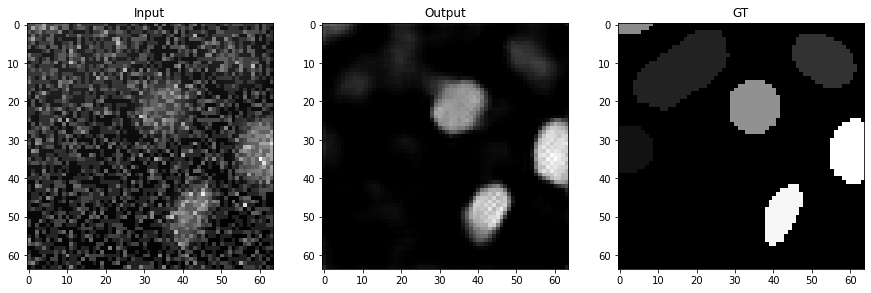

 -- Staring training epoch 57 --
train loss: 0.09265333045377361
validation loss: 0.08757510515054708


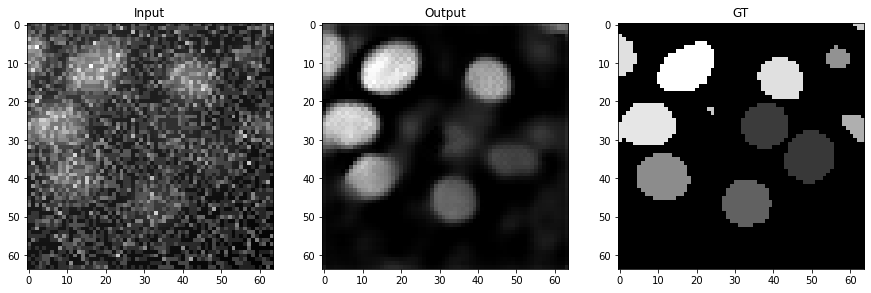

 -- Staring training epoch 58 --
train loss: 0.07714030484757718
validation loss: 0.07721532436543817


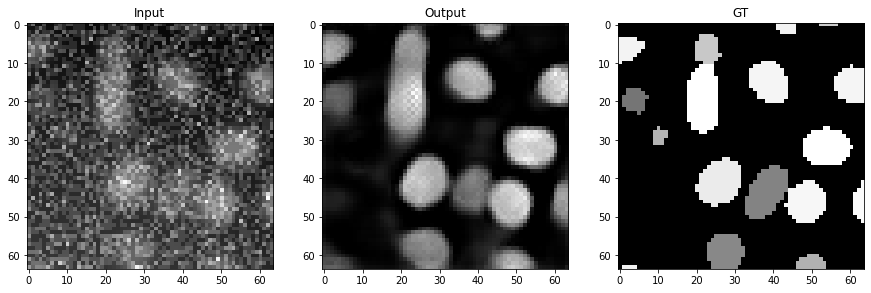

 -- Staring training epoch 59 --
train loss: 0.0818164471153048
validation loss: 0.07554391726850583


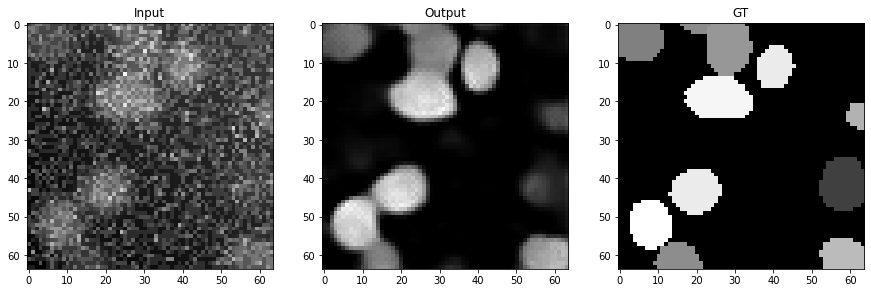

 -- Staring training epoch 60 --
train loss: 0.074503739162822
validation loss: 0.07247840160610239


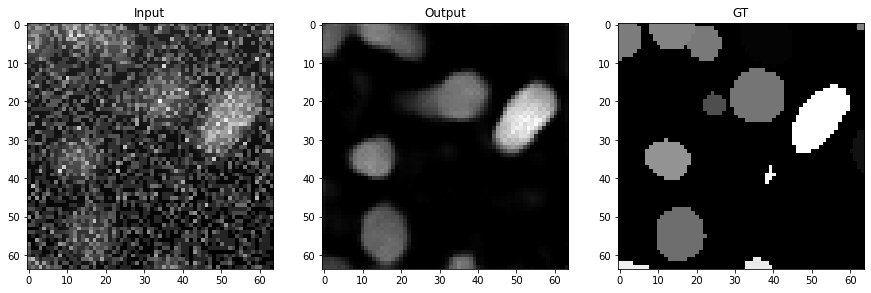

 -- Staring training epoch 61 --
train loss: 0.08501171535085243
validation loss: 0.07732026733593501


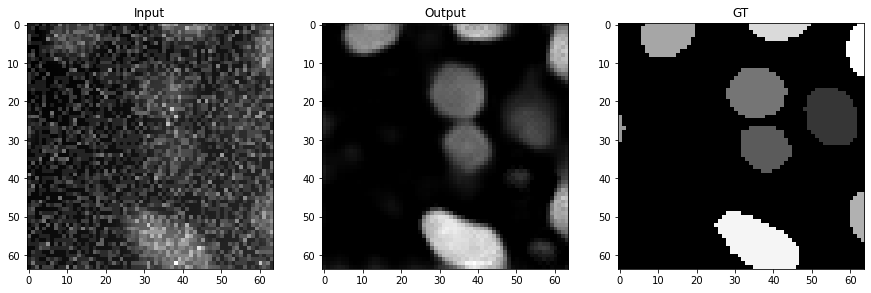

 -- Staring training epoch 62 --
train loss: 0.07633968140780838
validation loss: 0.08397974511279761


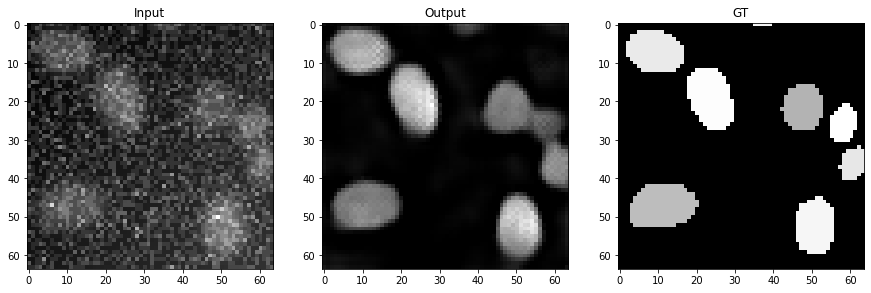

 -- Staring training epoch 63 --
train loss: 0.0740080649038904
validation loss: 0.07334557231362916


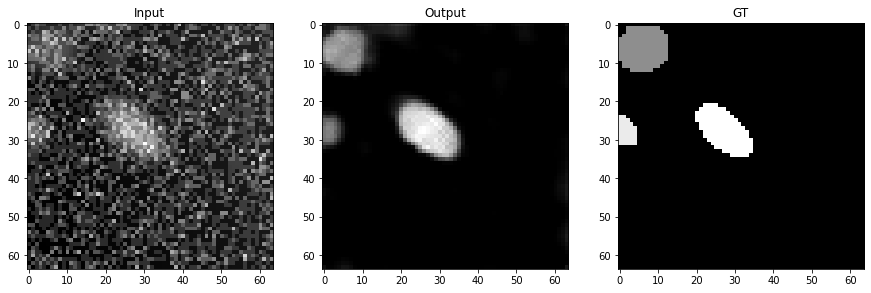

 -- Staring training epoch 64 --
train loss: 0.0819264074944534
validation loss: 0.07068995666568184


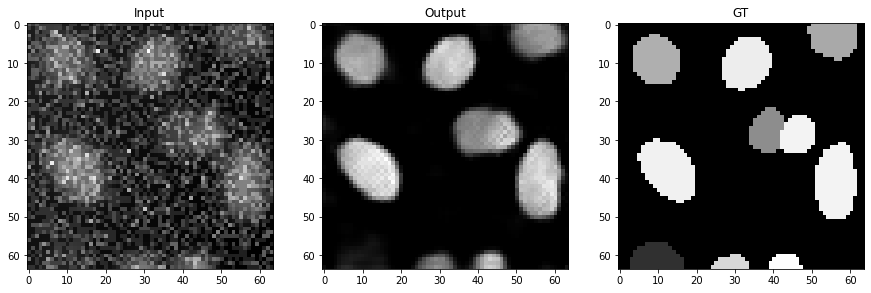

 -- Staring training epoch 65 --
train loss: 0.08139294919173602
validation loss: 0.0668191713960646


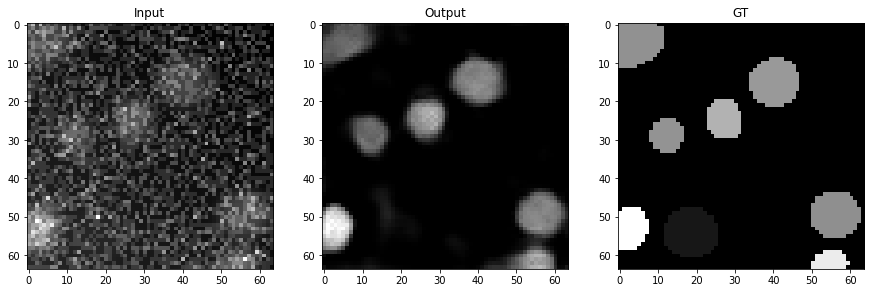

 -- Staring training epoch 66 --
train loss: 0.08627326172889212
validation loss: 0.07487840367972277


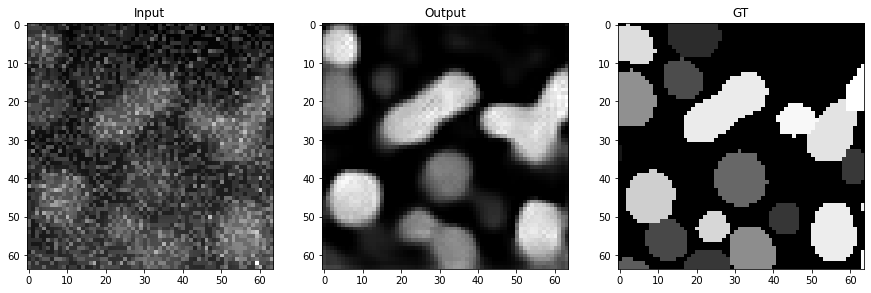

 -- Staring training epoch 67 --
train loss: 0.08374470784279808
validation loss: 0.06851736770140109


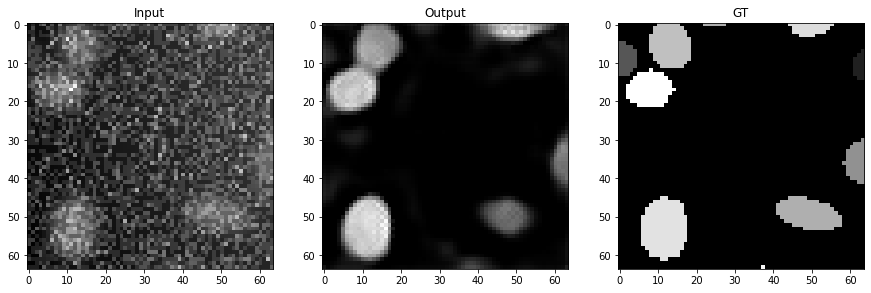

 -- Staring training epoch 68 --
train loss: 0.08119376482644823
validation loss: 0.06869536247907847


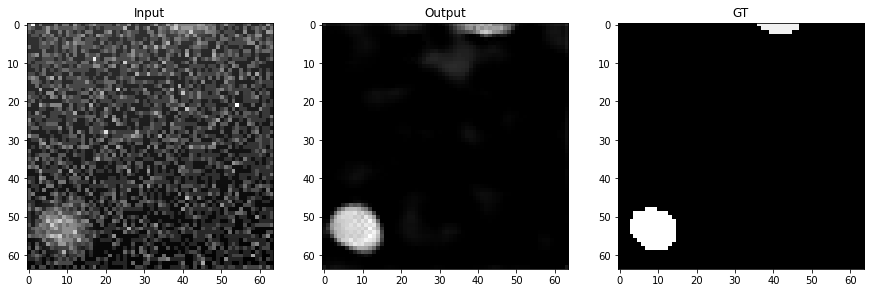

 -- Staring training epoch 69 --
train loss: 0.0709724972341029
validation loss: 0.08383338653484229


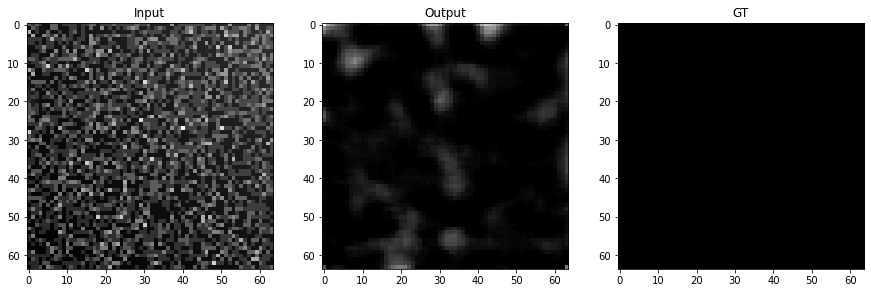

 -- Staring training epoch 70 --
train loss: 0.07160535608837494
validation loss: 0.07029849860383479


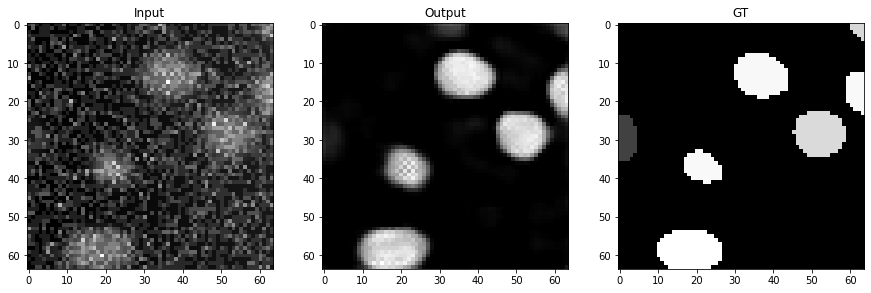

 -- Staring training epoch 71 --
train loss: 0.07276798798965055
validation loss: 0.06794908543121209


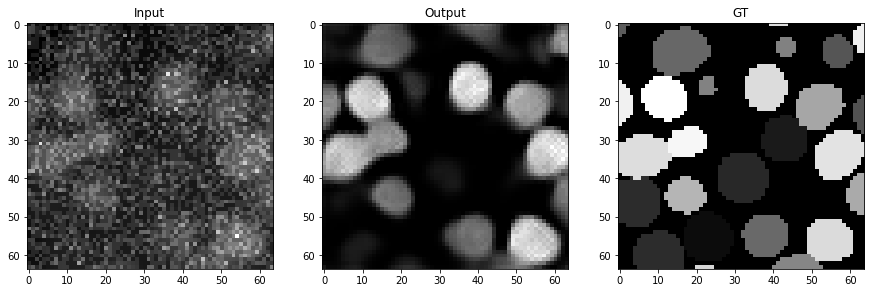

 -- Staring training epoch 72 --
train loss: 0.07371884795023348
validation loss: 0.0721979815457341


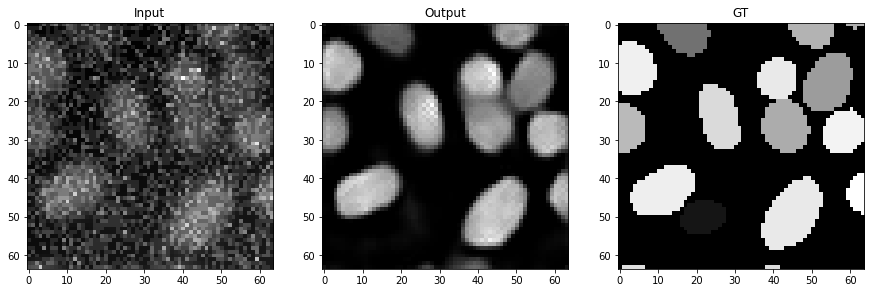

 -- Staring training epoch 73 --
train loss: 0.08582207972620602
validation loss: 0.092124257073606


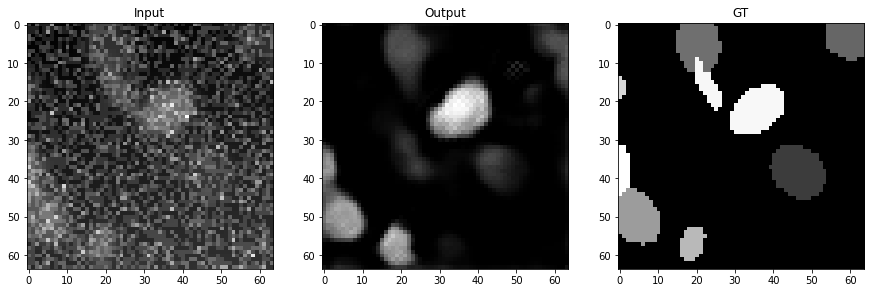

 -- Staring training epoch 74 --
train loss: 0.09566720444809894
validation loss: 0.08055336745848539


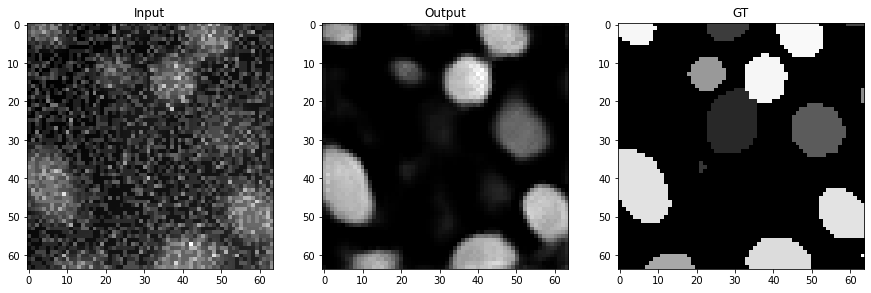

 -- Staring training epoch 75 --
train loss: 0.07645053585211921
validation loss: 0.07257791626619674


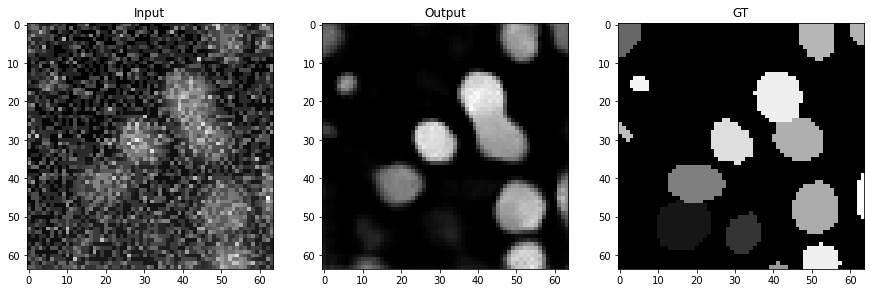

 -- Staring training epoch 76 --
train loss: 0.07798782852235155
validation loss: 0.06700301376284024


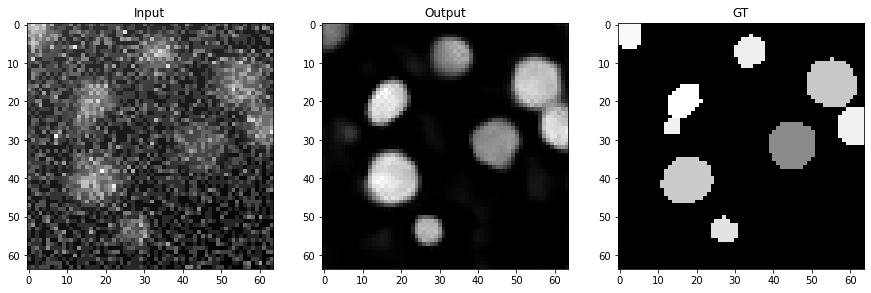

 -- Staring training epoch 77 --
train loss: 0.0721111432493836
validation loss: 0.06724340135582682


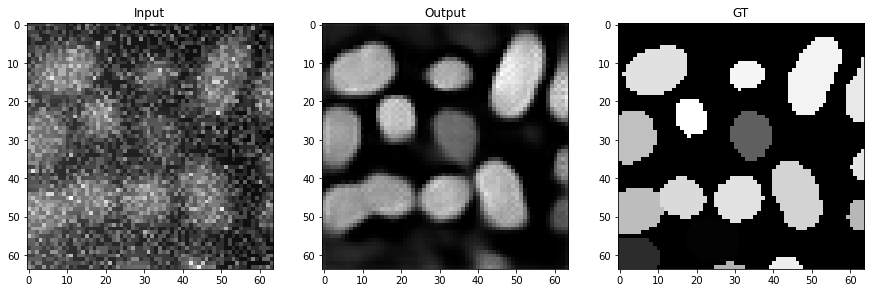

 -- Staring training epoch 78 --
train loss: 0.07063075252271968
validation loss: 0.07017192971075825


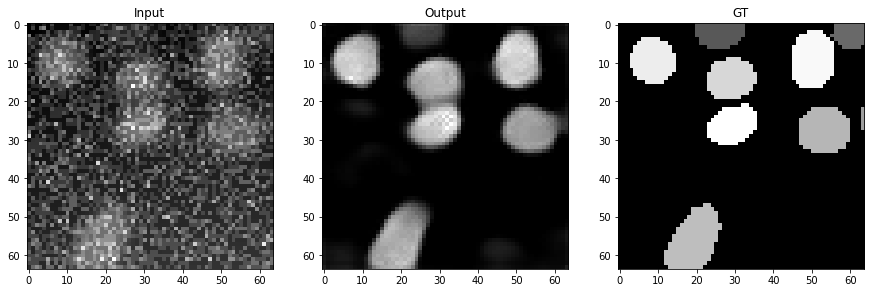

 -- Staring training epoch 79 --
train loss: 0.07233866221430182
validation loss: 0.07894674237301154


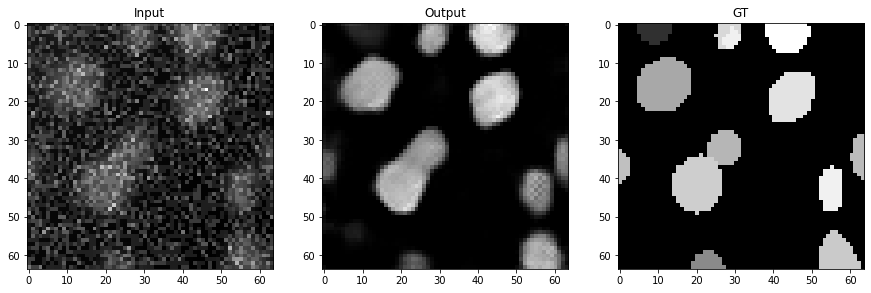

 -- Staring training epoch 80 --
train loss: 0.0698657378027033
validation loss: 0.06837436493674763


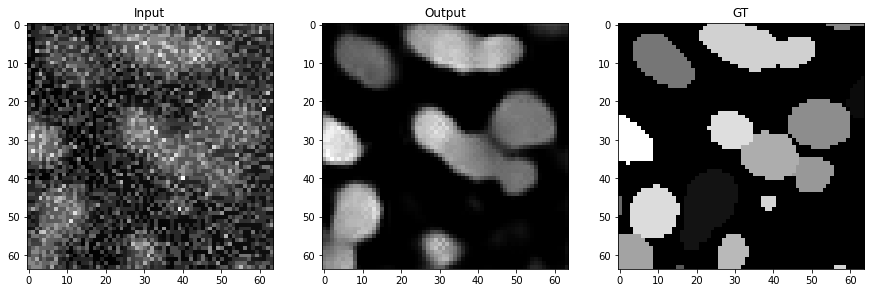

 -- Staring training epoch 81 --
train loss: 0.07720434499848779
validation loss: 0.07034381229436777


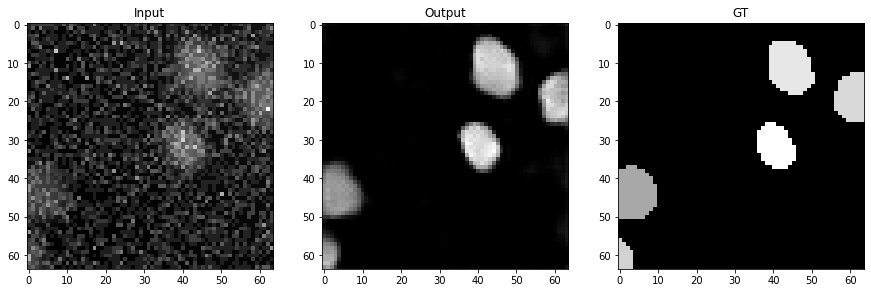

 -- Staring training epoch 82 --
train loss: 0.08682184707875996
validation loss: 0.08546270537408258


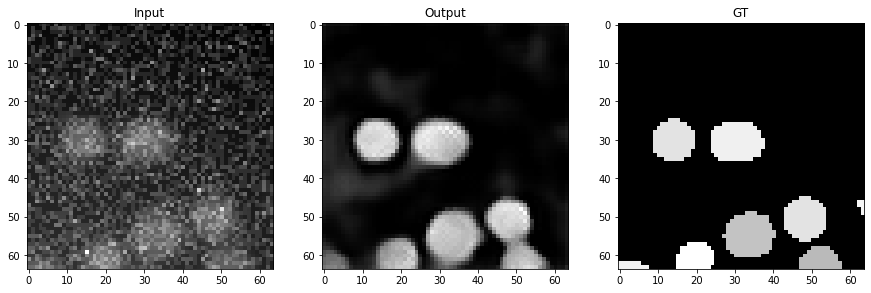

 -- Staring training epoch 83 --
train loss: 0.06900578228726749
validation loss: 0.0632257812881929


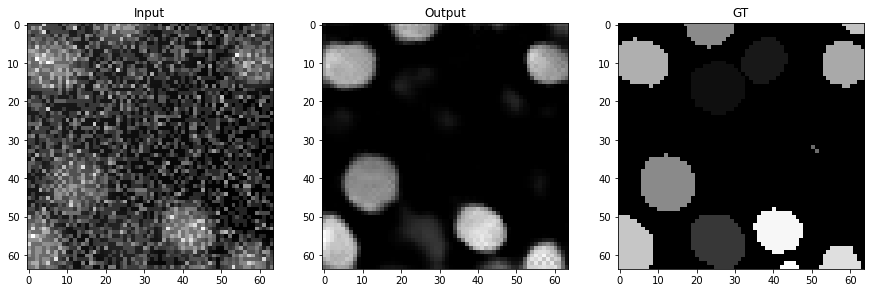

 -- Staring training epoch 84 --
train loss: 0.09440804516856742
validation loss: 0.07087292310600267


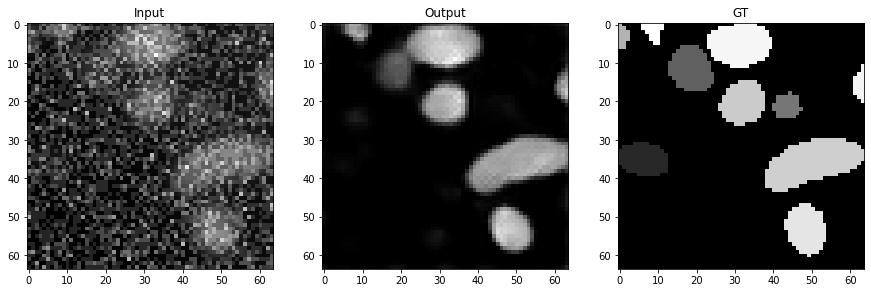

 -- Staring training epoch 85 --
train loss: 0.08114319066302463
validation loss: 0.06601758290130506


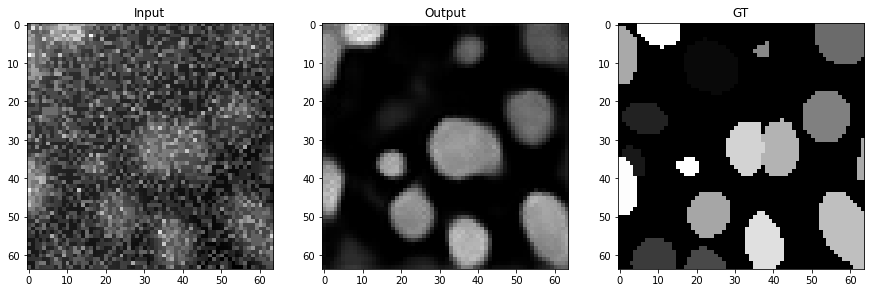

 -- Staring training epoch 86 --
train loss: 0.08294858675166515
validation loss: 0.06941290052624628


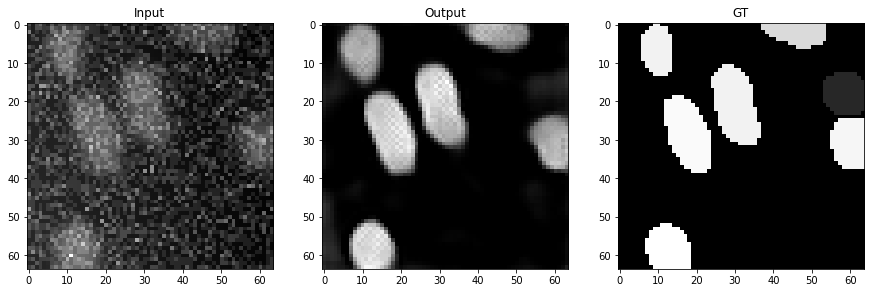

 -- Staring training epoch 87 --
train loss: 0.07529541541708756
validation loss: 0.1221661914684865


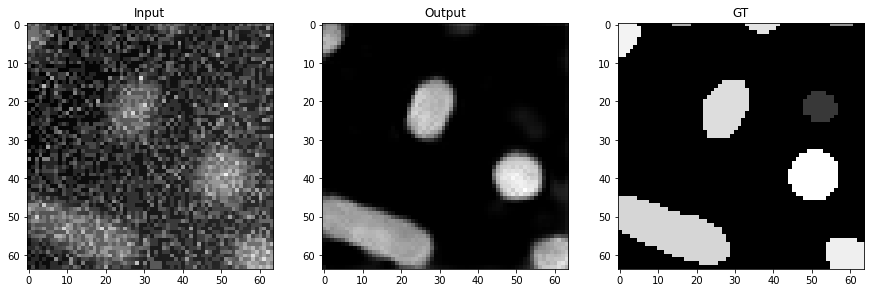

 -- Staring training epoch 88 --
train loss: 0.07505930751093287
validation loss: 0.07510650068933396


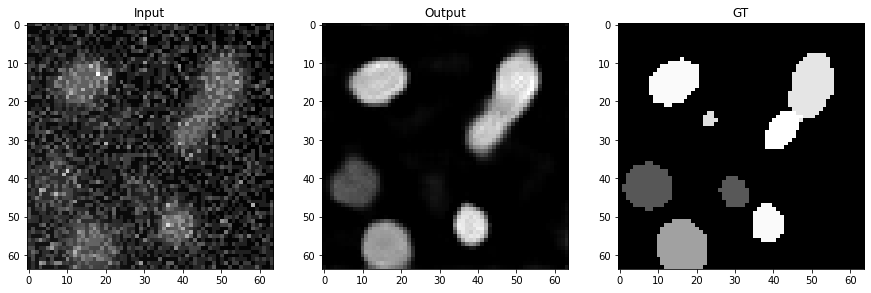

 -- Staring training epoch 89 --
train loss: 0.07076620952643829
validation loss: 0.06730433995489178


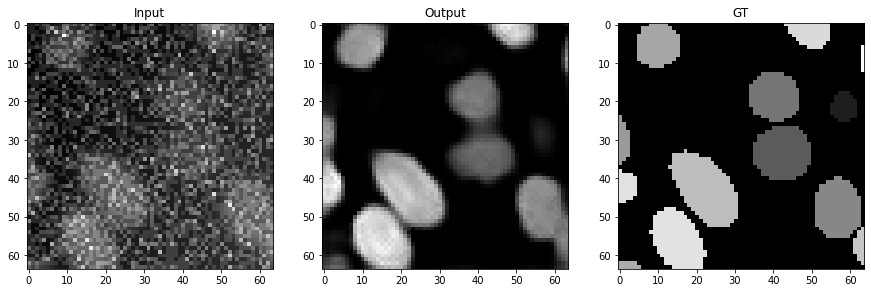

 -- Staring training epoch 90 --
train loss: 0.07673752031118565
validation loss: 0.07712994154847601


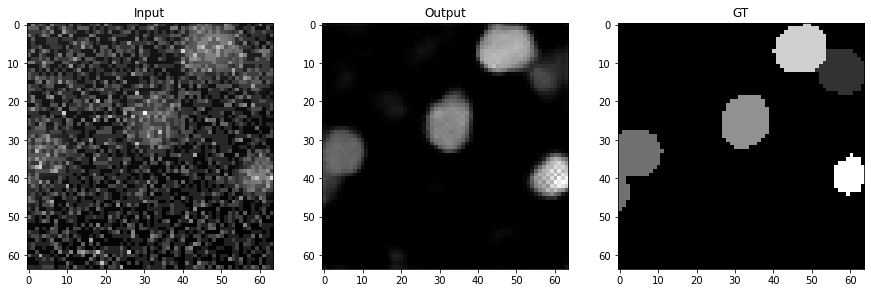

 -- Staring training epoch 91 --
train loss: 0.068445099110525
validation loss: 0.07237011314480872


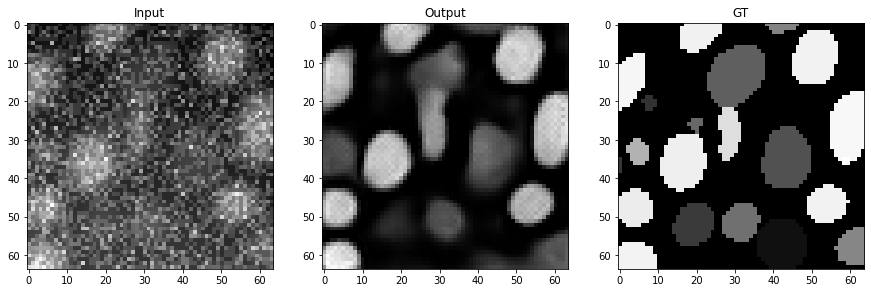

 -- Staring training epoch 92 --
train loss: 0.07755867450853317
validation loss: 0.06945907177199828


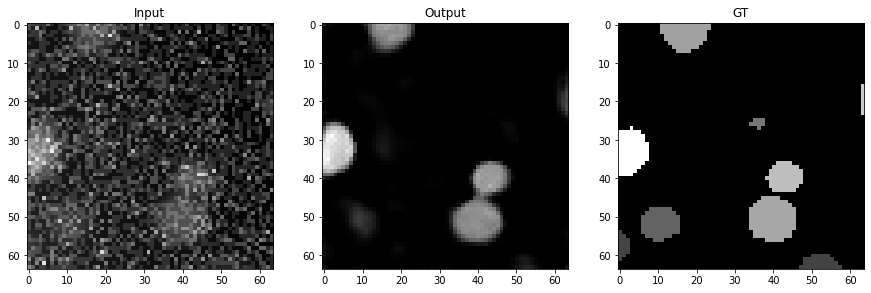

 -- Staring training epoch 93 --
train loss: 0.07050775552929911
validation loss: 0.06895850486204158


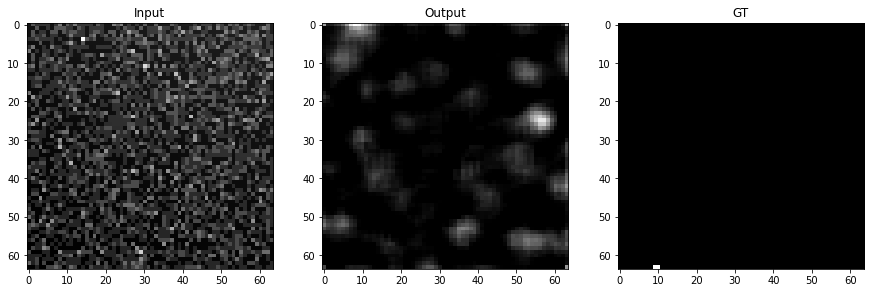

 -- Staring training epoch 94 --
train loss: 0.0695912010840095
validation loss: 0.07516521231544974


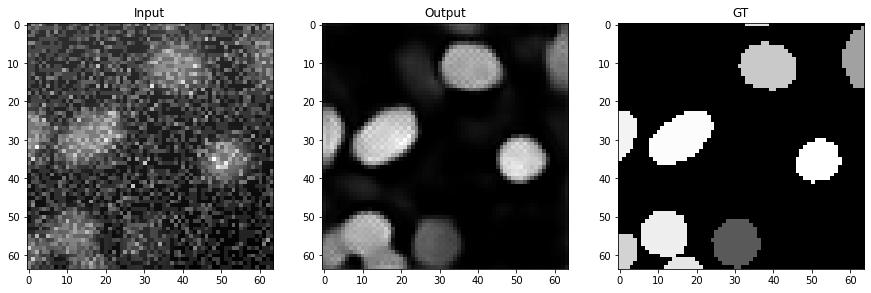

 -- Staring training epoch 95 --
train loss: 0.06682325445206068
validation loss: 0.06873384222078359


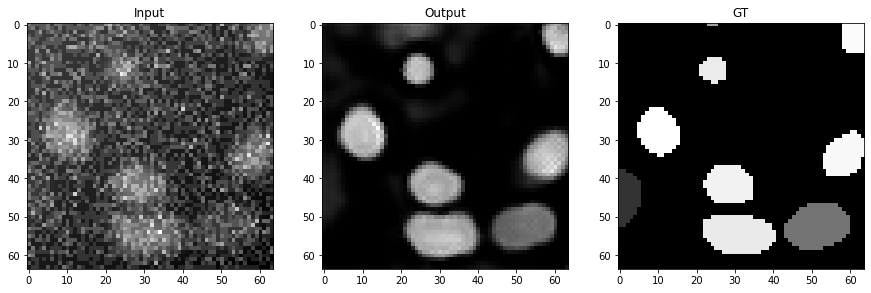

 -- Staring training epoch 96 --
train loss: 0.07180734660935319
validation loss: 0.27342704757279473


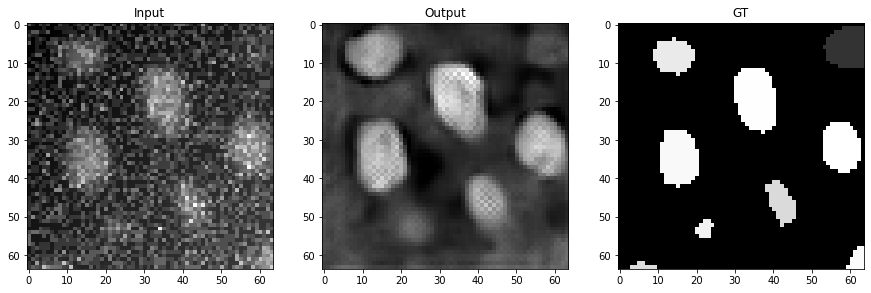

 -- Staring training epoch 97 --
train loss: 0.08227909397450281
validation loss: 0.07216553913486409


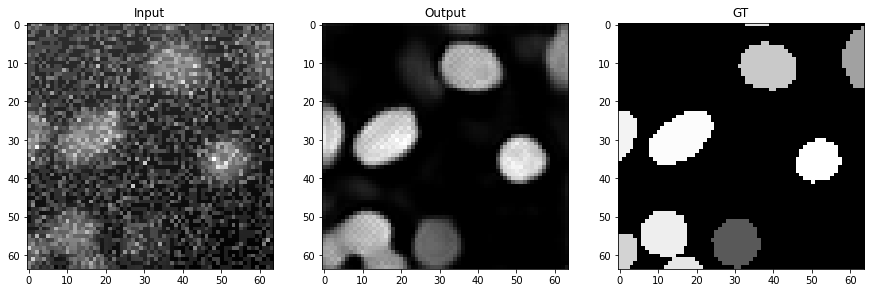

 -- Staring training epoch 98 --
train loss: 0.06928594504228107
validation loss: 0.06864746177127333


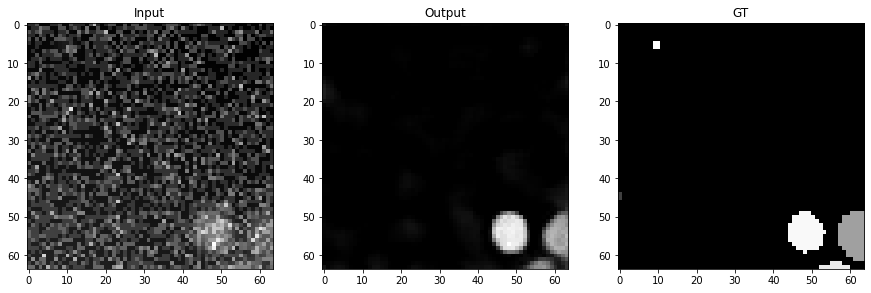

 -- Staring training epoch 99 --
train loss: 0.06956439540317086
validation loss: 0.06197652360853303


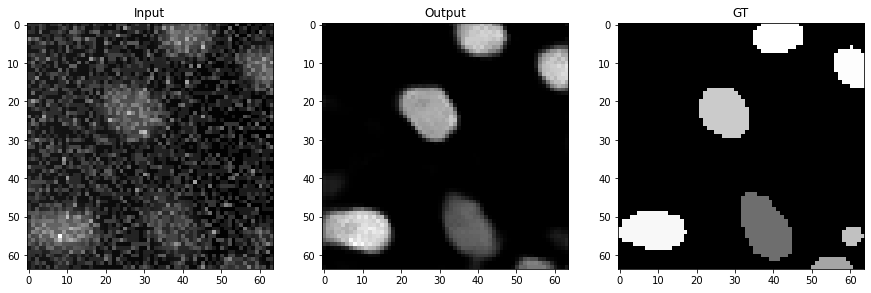

 -- Staring training epoch 100 --
train loss: 0.06833003748544032
validation loss: 0.06420571806642235


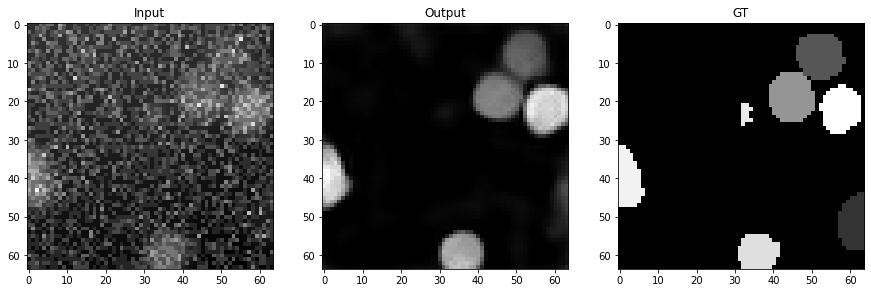

 -- Staring training epoch 101 --
train loss: 0.06748128811772312
validation loss: 0.06905058601169815


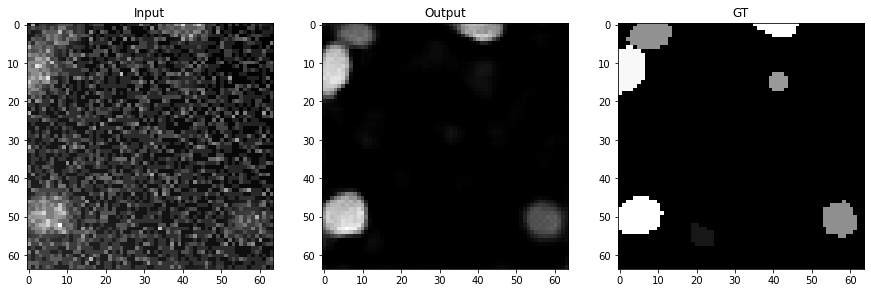

 -- Staring training epoch 102 --
train loss: 0.07625539544726855
validation loss: 0.06864112039353781


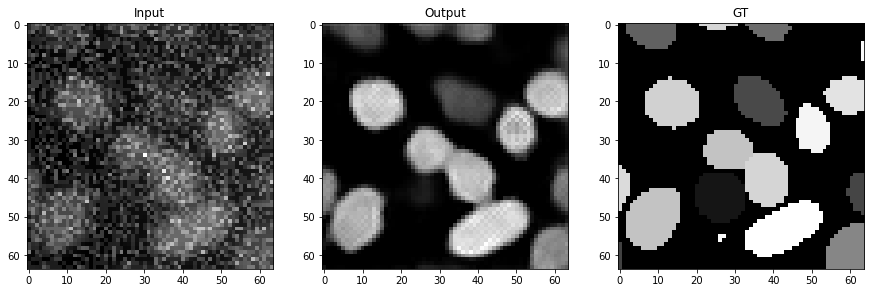

 -- Staring training epoch 103 --
train loss: 0.08133520843518714
validation loss: 0.06296626834837532


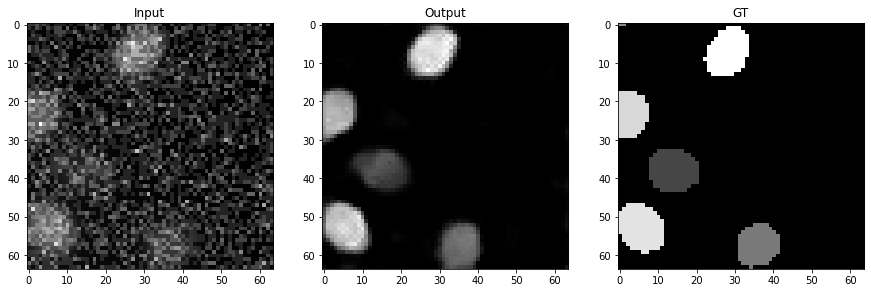

 -- Staring training epoch 104 --
train loss: 0.06917400769580291
validation loss: 0.08396788770477541


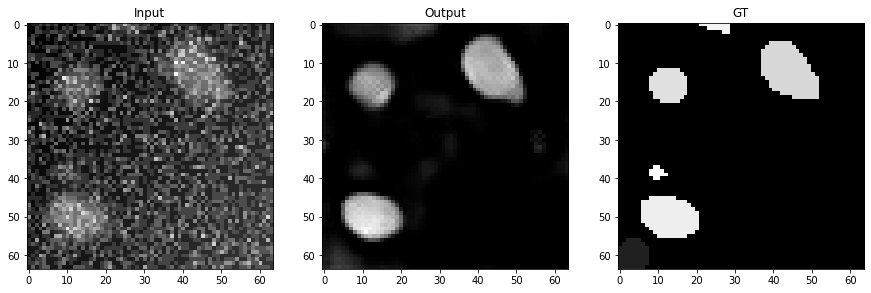

 -- Staring training epoch 105 --
train loss: 0.07157537736143009
validation loss: 0.0631824441248437


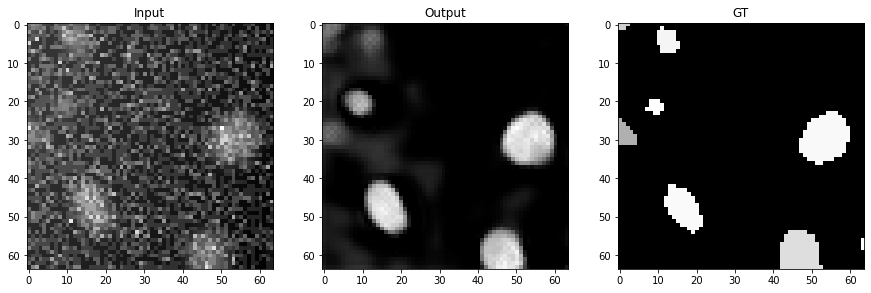

 -- Staring training epoch 106 --
train loss: 0.0827781061571321
validation loss: 0.07505545736543513


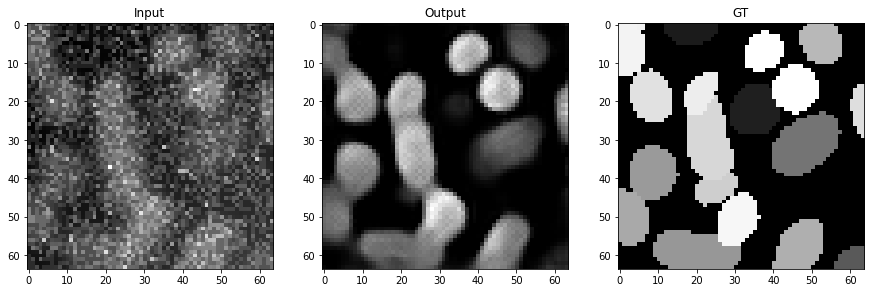

 -- Staring training epoch 107 --
train loss: 0.07640334215629058
validation loss: 0.08385207143766399


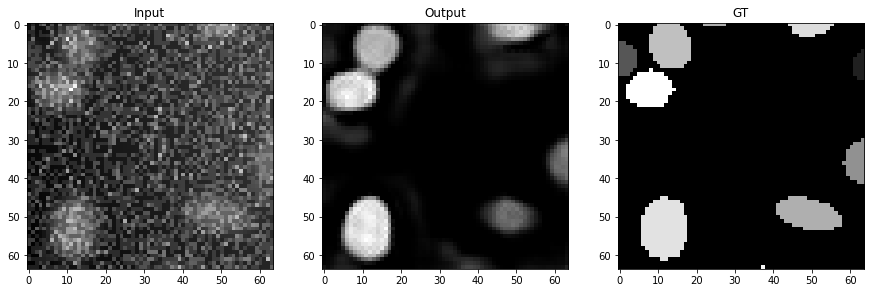

 -- Staring training epoch 108 --
train loss: 0.0751536941528274
validation loss: 0.06743991109481677


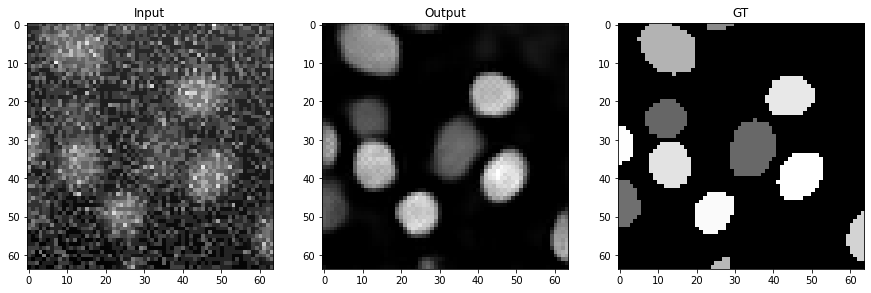

 -- Staring training epoch 109 --
train loss: 0.06766153340301441
validation loss: 0.07093261293286737


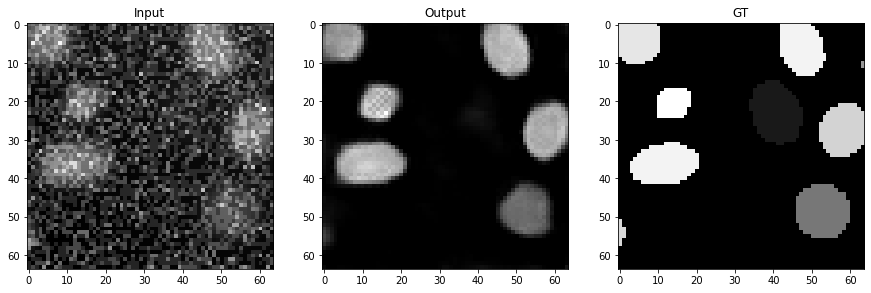

 -- Staring training epoch 110 --
train loss: 0.06810678653964354
validation loss: 0.07792126081618066


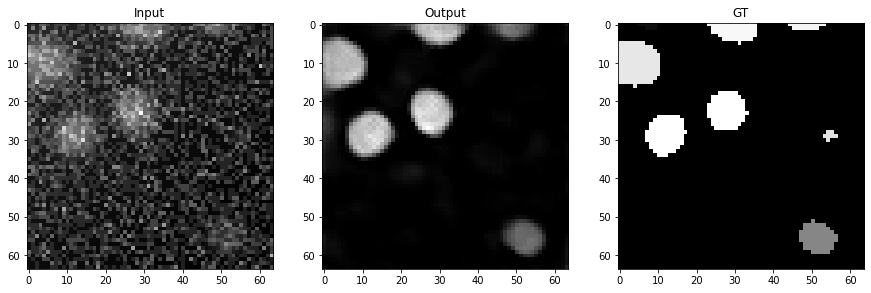

 -- Staring training epoch 111 --
train loss: 0.06740920408205789
validation loss: 0.06312575634600909


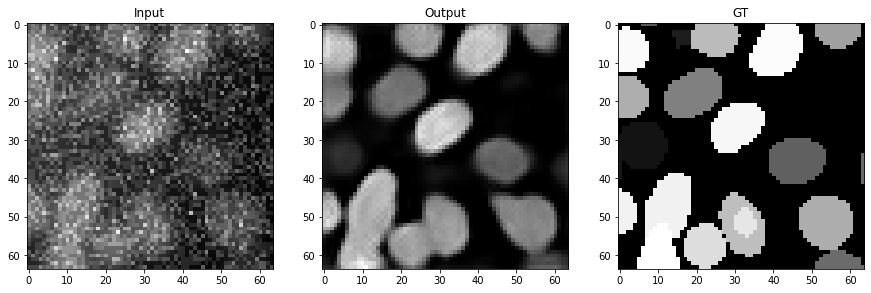

 -- Staring training epoch 112 --
train loss: 0.06730936500814104
validation loss: 0.0638305232607252


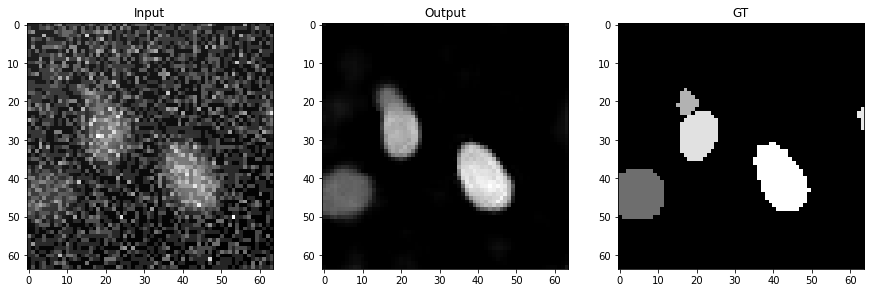

 -- Staring training epoch 113 --
train loss: 0.0767129242381184
validation loss: 0.07330828828282403


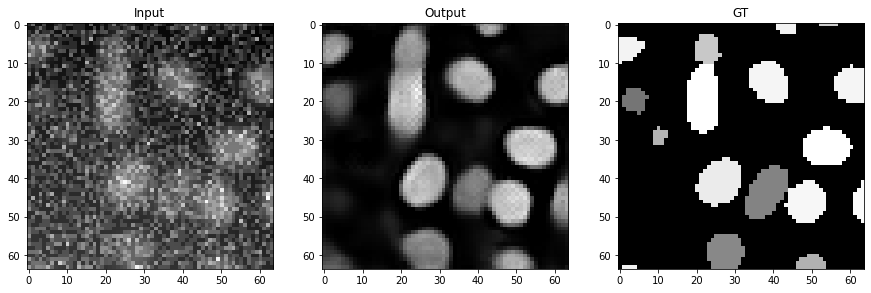

 -- Staring training epoch 114 --
train loss: 0.07081720326006845
validation loss: 0.06542330755454513


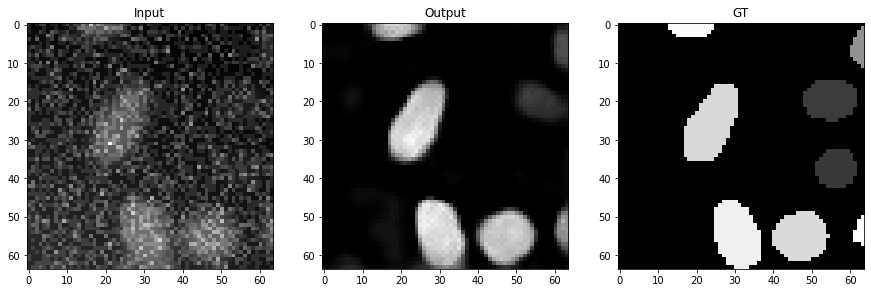

 -- Staring training epoch 115 --
train loss: 0.07899523531792517
validation loss: 0.08192232792911967


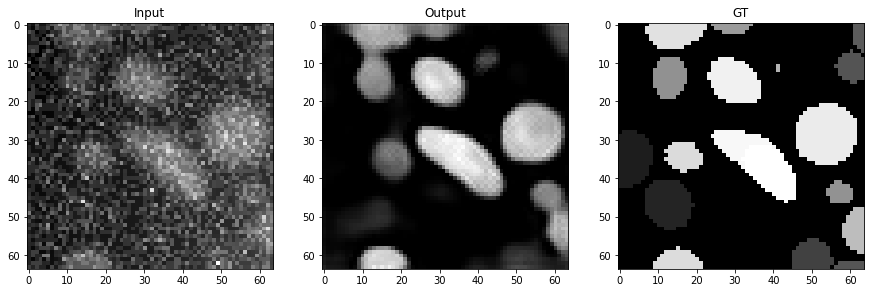

 -- Staring training epoch 116 --
train loss: 0.07131557919717356
validation loss: 0.0635424215641739


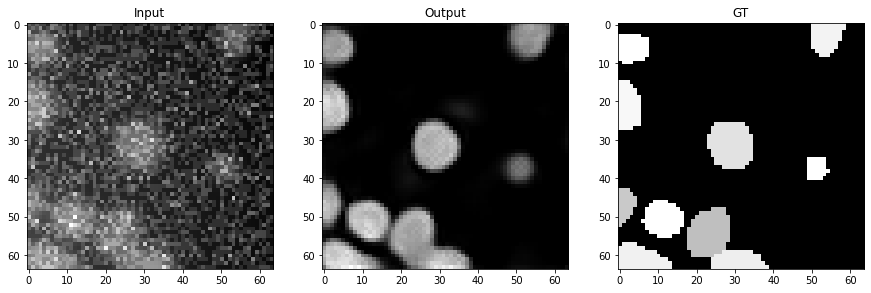

 -- Staring training epoch 117 --
train loss: 0.06986762437976081
validation loss: 0.06476846125191224


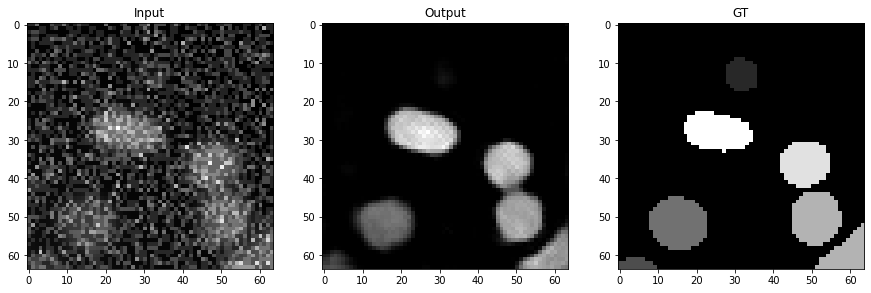

 -- Staring training epoch 118 --
train loss: 0.06897475595908968
validation loss: 0.06343682332379556


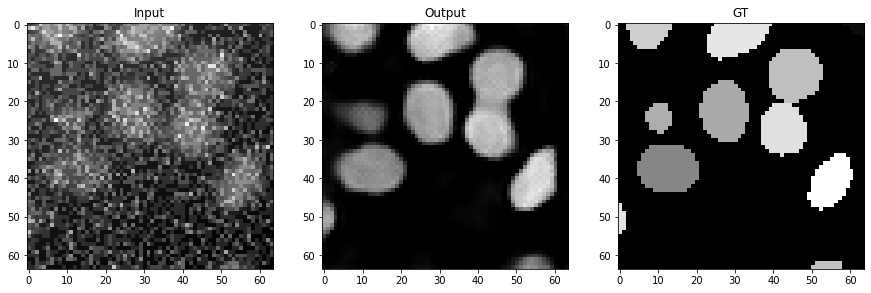

 -- Staring training epoch 119 --
train loss: 0.06865124383094702
validation loss: 0.06307636620998079


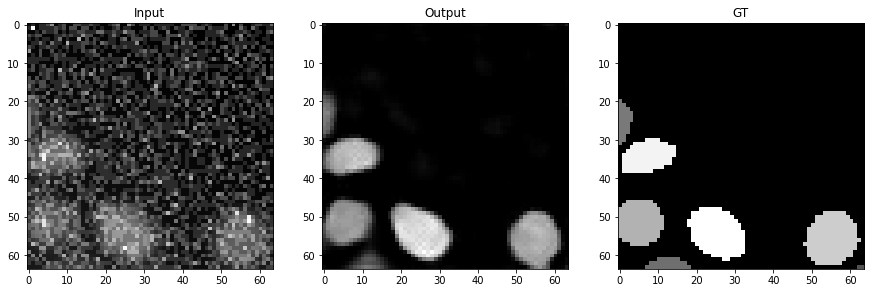

 -- Staring training epoch 120 --
train loss: 0.06632707465106492
validation loss: 0.07001101485061116


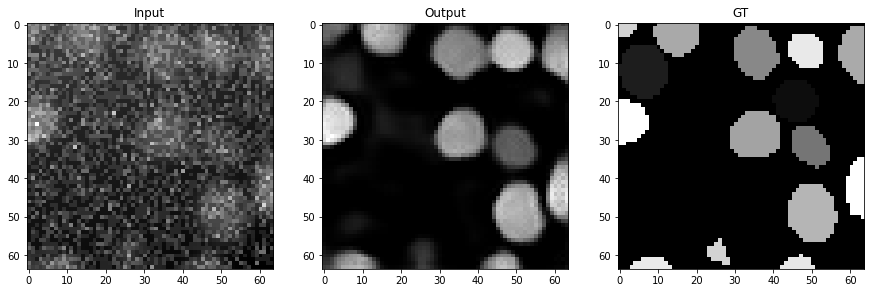

 -- Staring training epoch 121 --
train loss: 0.06625746583432539
validation loss: 0.060829056750444394


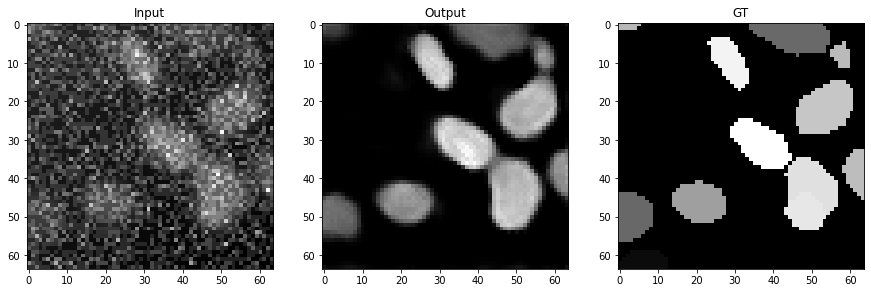

 -- Staring training epoch 122 --
train loss: 0.06732880905675731
validation loss: 0.06793182519196146


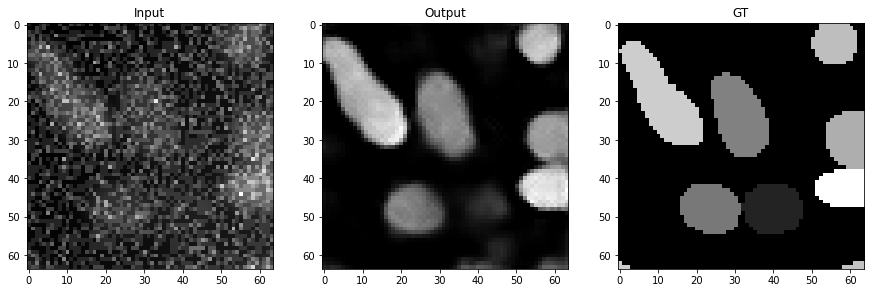

 -- Staring training epoch 123 --
train loss: 0.06708634691603664
validation loss: 0.06953724185965561


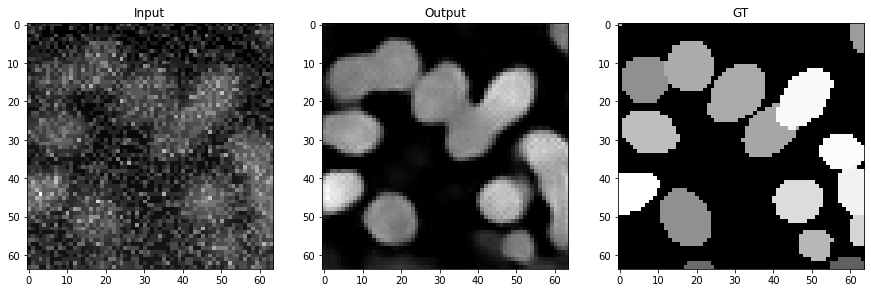

 -- Staring training epoch 124 --
train loss: 0.07240473585584263
validation loss: 0.06994974361928803


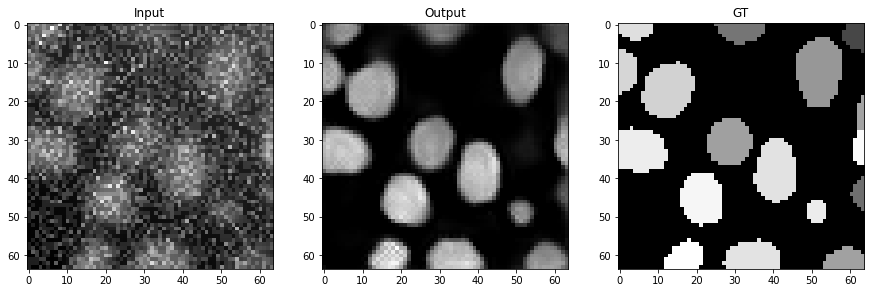

 -- Staring training epoch 125 --
train loss: 0.06950565511990407
validation loss: 0.0716792426359258


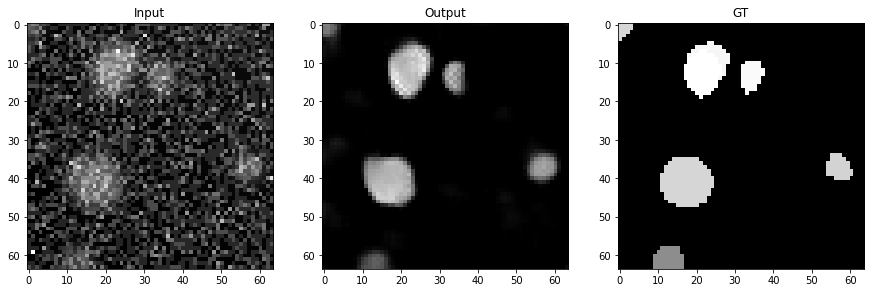

 -- Staring training epoch 126 --
train loss: 0.066987221250187
validation loss: 0.0850480349015843


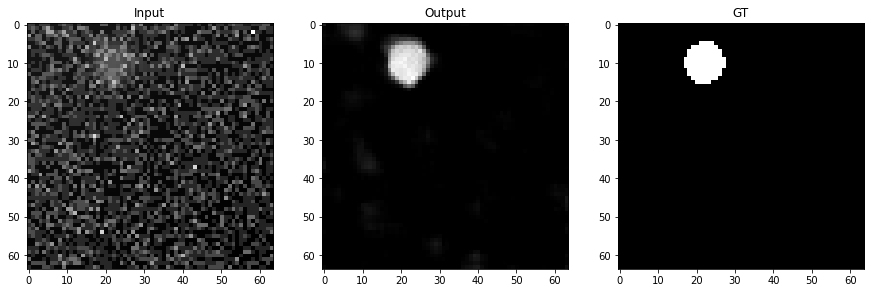

 -- Staring training epoch 127 --
train loss: 0.07736640327380025
validation loss: 0.061591317357611


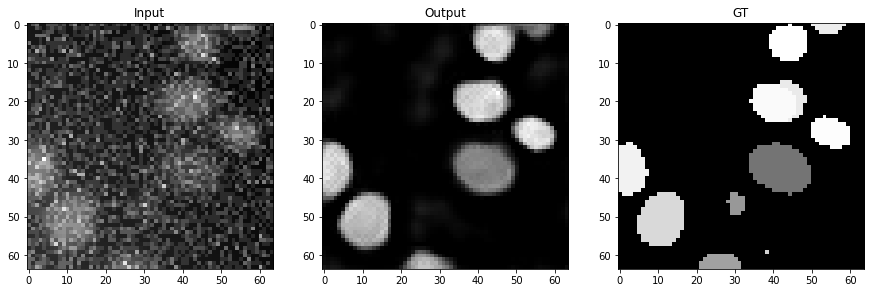

 -- Staring training epoch 128 --
train loss: 0.07252958682231438
validation loss: 0.0659823170348154


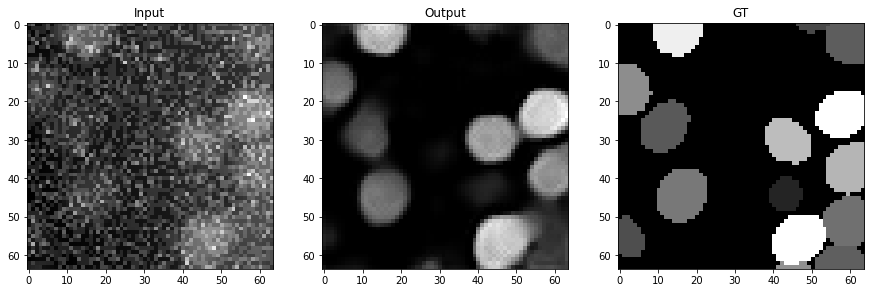

 -- Staring training epoch 129 --
train loss: 0.06901037607435946
validation loss: 0.06151443608569158


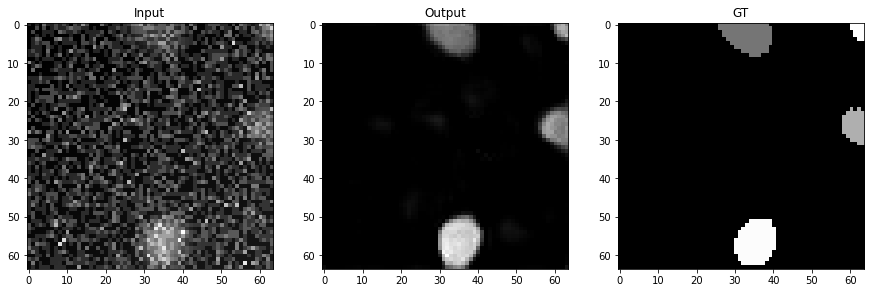

 -- Staring training epoch 130 --
train loss: 0.06895218182666331
validation loss: 0.06153924357916424


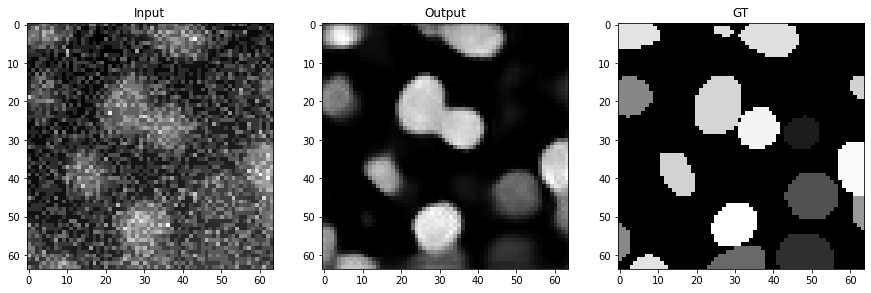

 -- Staring training epoch 131 --
train loss: 0.06811846170273084
validation loss: 0.0738974860353266


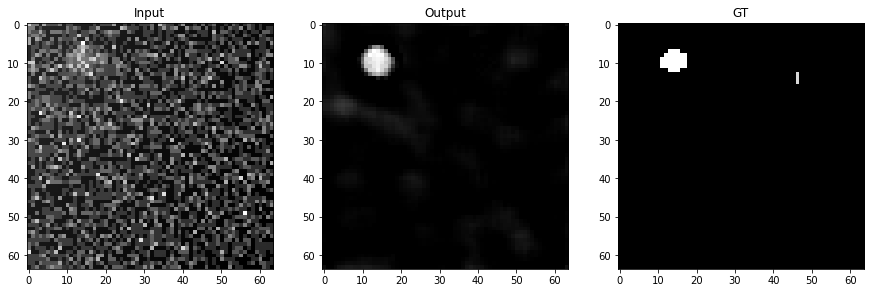

 -- Staring training epoch 132 --
train loss: 0.07323860459322616
validation loss: 0.07002346082906319


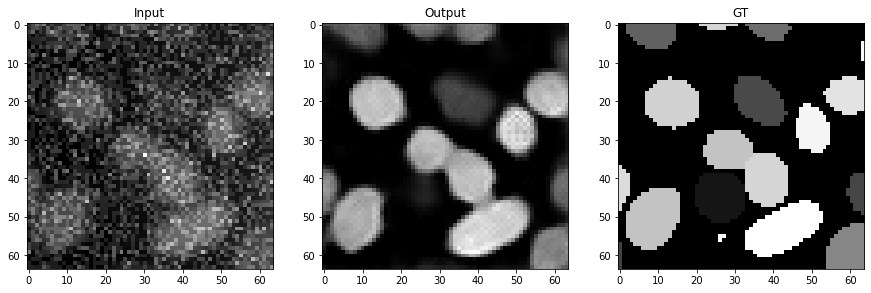

 -- Staring training epoch 133 --
train loss: 0.07512592035484615
validation loss: 0.061905754235425714


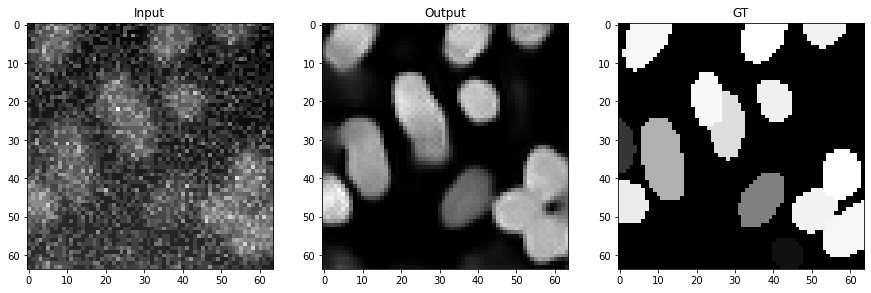

 -- Staring training epoch 134 --
train loss: 0.06533669260912964
validation loss: 0.060017239914030074


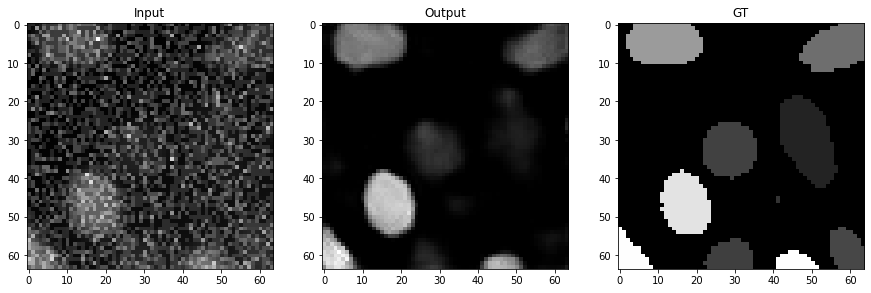

 -- Staring training epoch 135 --
train loss: 0.068167918578762
validation loss: 0.06257257436871645


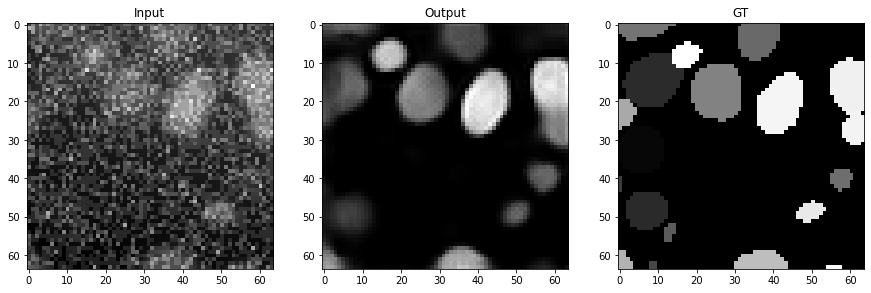

 -- Staring training epoch 136 --
train loss: 0.06671354848351005
validation loss: 0.064131479905102


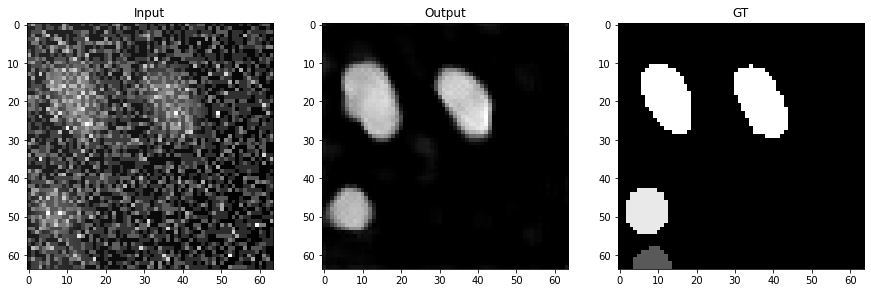

 -- Staring training epoch 137 --
train loss: 0.06378893735526595
validation loss: 0.06382200207810214


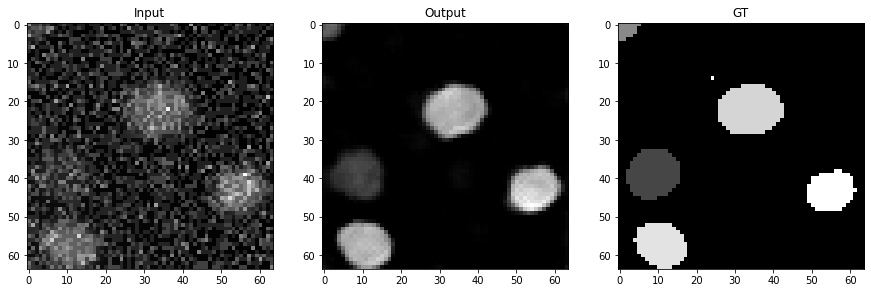

 -- Staring training epoch 138 --
train loss: 0.06577490013233693
validation loss: 0.0707742343278129


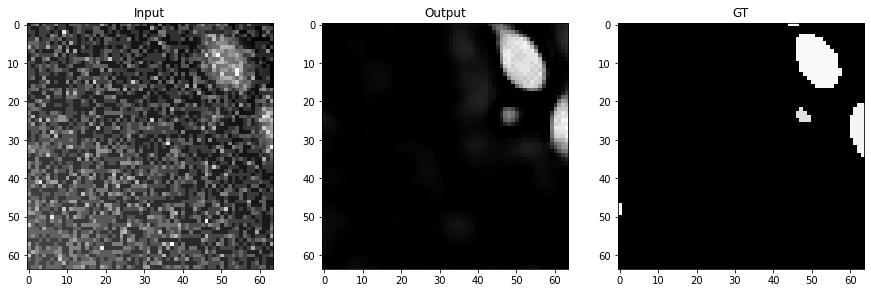

 -- Staring training epoch 139 --
train loss: 0.0728349113534859
validation loss: 0.12636221406577577


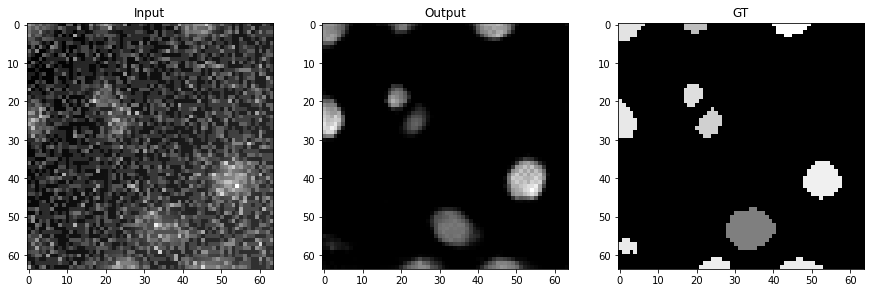

 -- Staring training epoch 140 --
train loss: 0.09088134342670329
validation loss: 0.08166872792809295


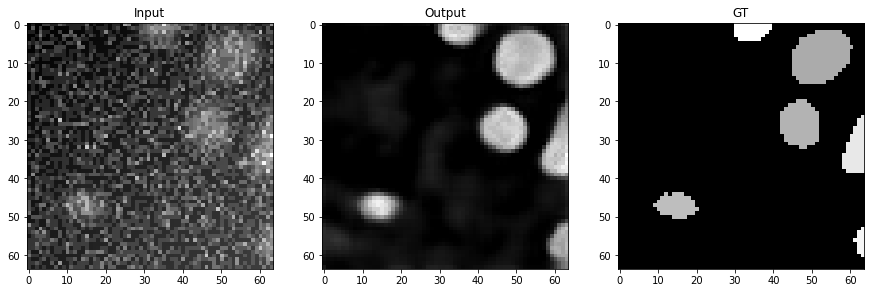

 -- Staring training epoch 141 --
train loss: 0.06902168813008479
validation loss: 0.06365991879012305


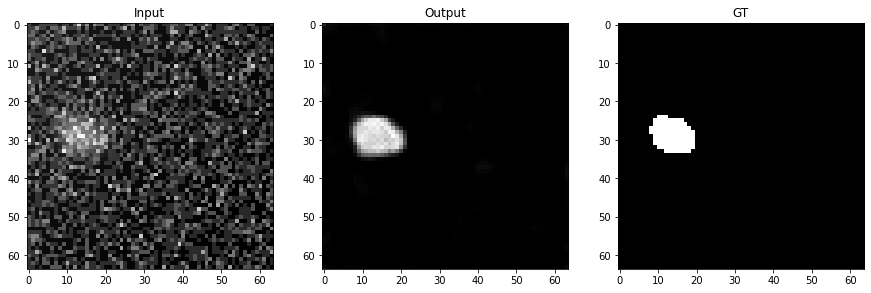

 -- Staring training epoch 142 --
train loss: 0.0718965518638539
validation loss: 0.0660679520895626


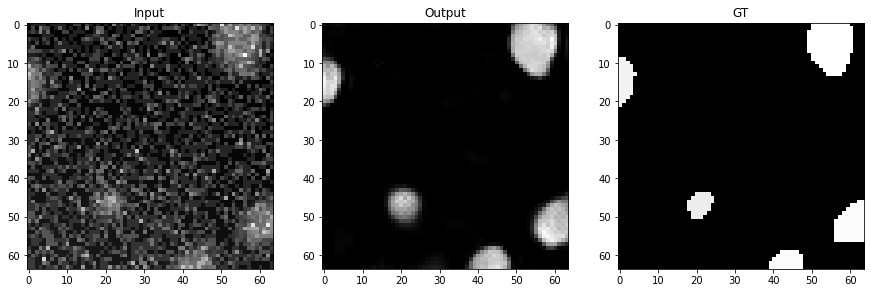

 -- Staring training epoch 143 --
train loss: 0.06795148035485009
validation loss: 0.07764375361378148


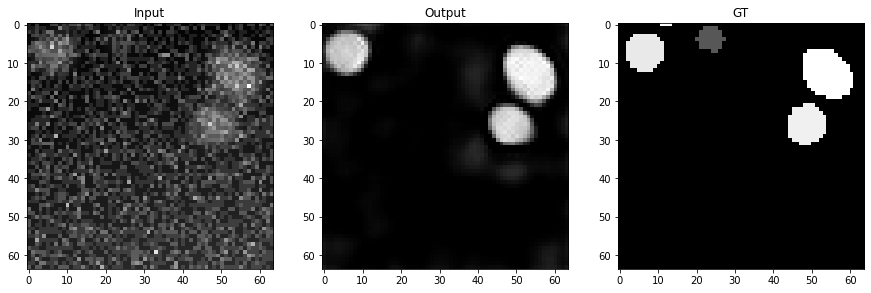

 -- Staring training epoch 144 --
train loss: 0.06752461622386692
validation loss: 0.0691304977744873


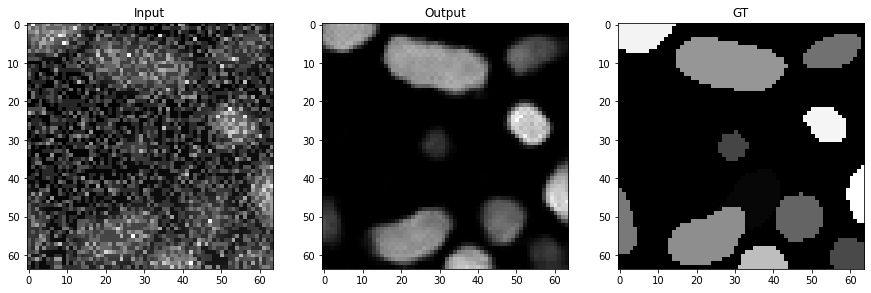

 -- Staring training epoch 145 --
train loss: 0.06708919652659472
validation loss: 0.06749707883006333


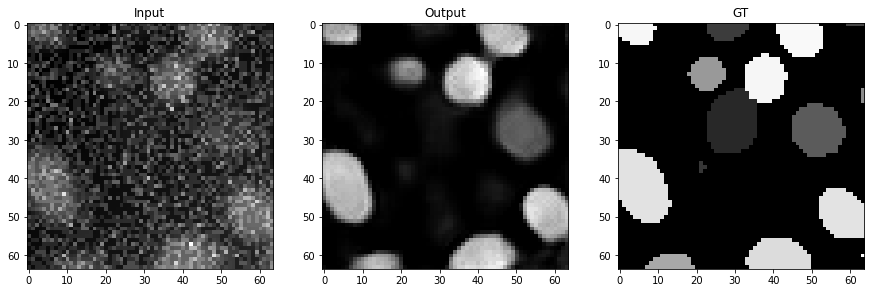

 -- Staring training epoch 146 --
train loss: 0.0720460929171075
validation loss: 0.51288299699536


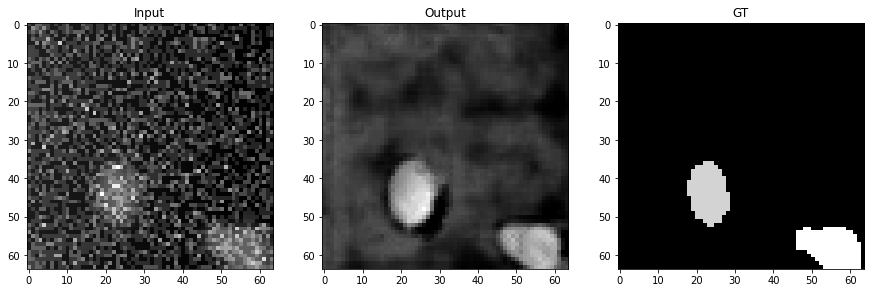

 -- Staring training epoch 147 --
train loss: 0.08026033837450947
validation loss: 0.07514767600820164


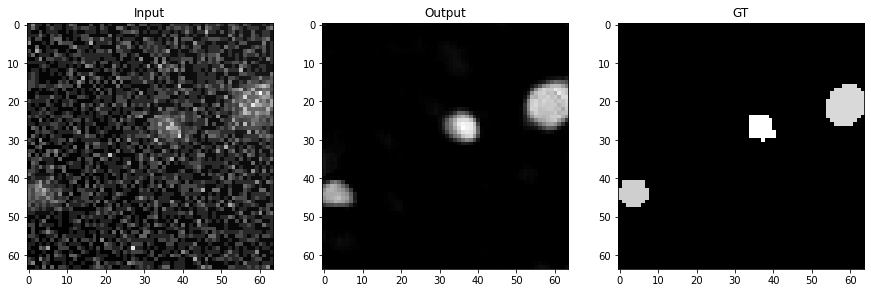

 -- Staring training epoch 148 --
train loss: 0.07701098359886223
validation loss: 0.060782963988706744


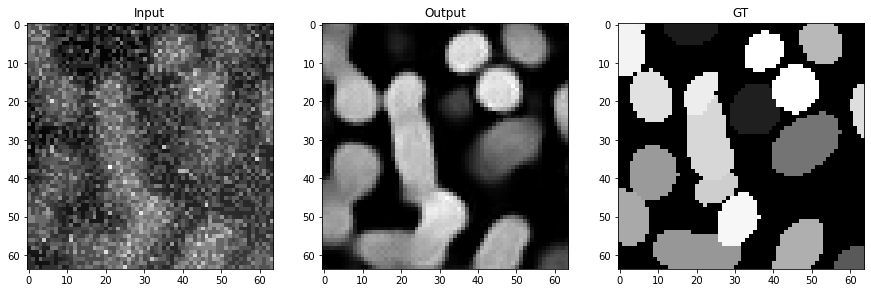

 -- Staring training epoch 149 --
train loss: 0.06666452708201283
validation loss: 0.0675502180628107


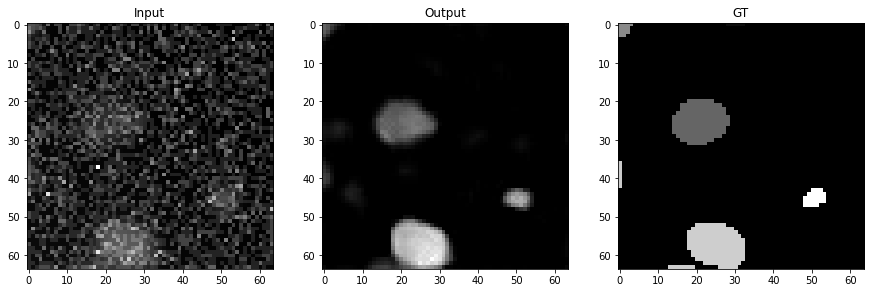

 -- Staring training epoch 150 --
train loss: 0.07415216261071102
validation loss: 0.09786055722234073


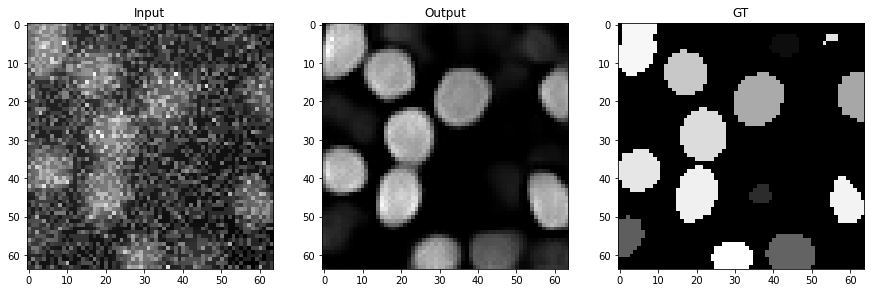

In [17]:
epochs = 150

for epoch in range(epochs):

    print(' -- Staring training epoch {} --'.format(epoch + 1))

    net.train()
    train_loss = []
    for x, y in rln_train_dataloader:
        x, y = x.to(device), y.to(device)

        opt.zero_grad()
        
        y_hat, y_temp = net(x.float())

        loss_main = mse_loss(y_hat.float(), y.float()) - torch.log((1+get_SSIM(y, y_hat))/2)
        loss_aux = mse_loss(y_temp.float(), y.float()*0.8 + x.float()*0.2)
        loss = loss_main + loss_aux
        loss.backward()
        opt.step()

        train_loss.append(loss.item())

    print('train loss: {}'.format(np.mean(np.array(train_loss))))


    net.eval()
    val_loss = []
    for x, y in rln_val_dataloader:
        x, y = x.to(device), y.to(device)

        y_hat, y_temp = net(x.float())

        loss_main = mse_loss(y_hat.float(), y.float()) - torch.log((1+get_SSIM(y, y_hat))/2)
        loss_aux = mse_loss(y_temp.float(), y.float()*0.8 + x.float()*0.2)
        loss = loss_main + loss_aux

        val_loss.append(loss.item())

    print('validation loss: {}'.format(np.mean(np.array(val_loss))))

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(x.detach().cpu().numpy()[0,0,0,:,:], cmap='gray')
    plt.title('Input')
    plt.subplot(1,3,2)
    plt.imshow(y_hat.detach().cpu().numpy()[0,0,0,:,:], cmap='gray')
    plt.title('Output')
    plt.subplot(1,3,3)
    plt.imshow(y.detach().cpu().numpy()[0,0,0,:,:], cmap='gray')
    plt.title('GT')
    plt.show()

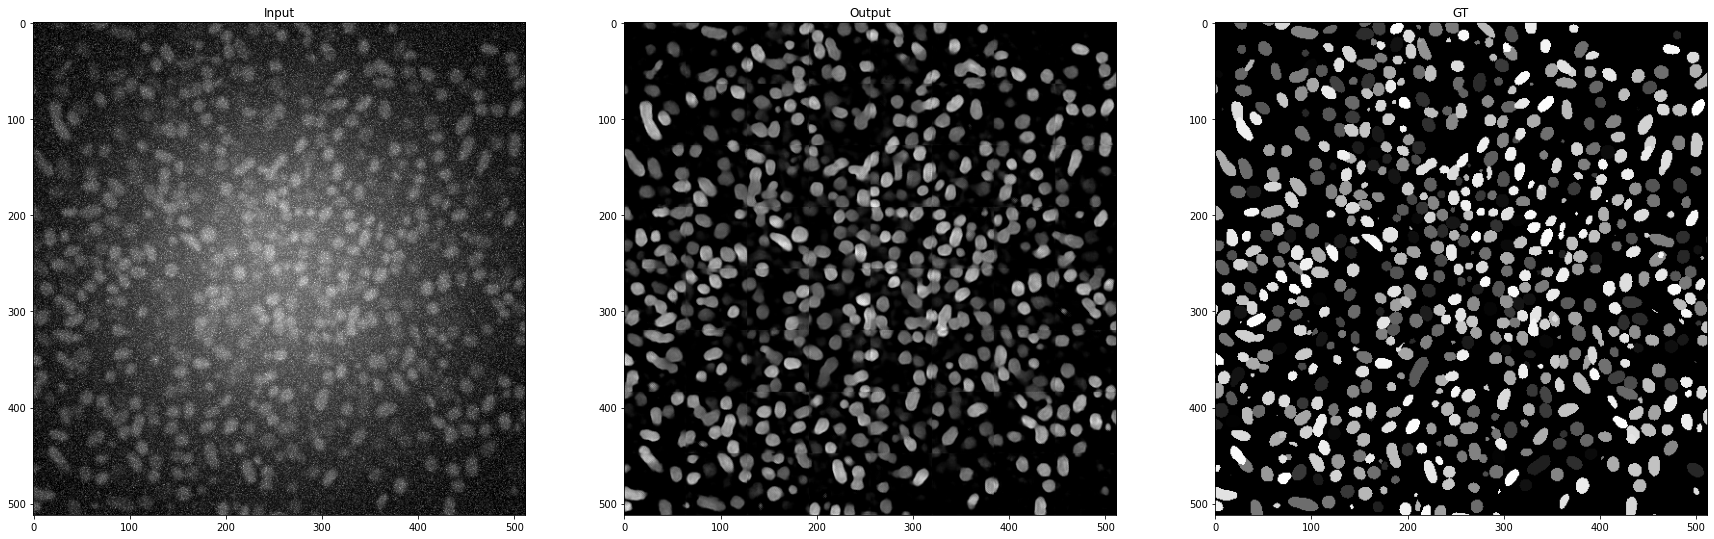

In [18]:
net.eval()

test_stack_gt = val_gt_data[:,:8,:,:].unsqueeze(0).to(device)
test_stack = val_blur_data[:,:8,:,:].unsqueeze(0).to(device)

canvas = np.zeros((512,512))

for i in range(8):
    for j in range(8):
        crop = test_stack[:,:,:,i*64:(i+1)*64,j*64:(j+1)*64]

        out, _ = net(crop.float())
        canvas[i*64:(i+1)*64,j*64:(j+1)*64] = out[0,0,0,:,:].detach().cpu().numpy()

plt.figure(figsize=(30,15))
plt.subplot(1,3,1)
plt.imshow(test_stack[0,0,0,:,:].detach().cpu().numpy(), cmap='gray')
plt.title('Input')
plt.subplot(1,3,2)
plt.imshow(canvas, cmap='gray')
plt.title('Output')
plt.subplot(1,3,3)
plt.imshow(test_stack_gt[0,0,0,:,:].detach().cpu().numpy(), cmap='gray')
plt.title('GT')
plt.show()

### Test on real data

In [19]:
im_true = tifffile.imread('Knutdata/B11.1_H5.4_frame_000001_Nz100(1).tif', maxworkers=6)

In [52]:
canvas = np.zeros(((im_true.shape[0]),512,512))

for t in range(12):
    test_true_stack = torch.from_numpy(im_true.astype(np.float64))[t*8:(t+1)*8,256:-256,256:-256].unsqueeze(0).unsqueeze(0).to(device)
    test_true_stack = (test_true_stack - torch.min(test_true_stack))/(torch.max(test_true_stack) - torch.min(test_true_stack))

    for i in range(8):
        for j in range(8):
            crop = test_true_stack[:,:,:,i*64:(i+1)*64,j*64:(j+1)*64]

            out, _ = net(crop.float())

            canvas[t*8:(t+1)*8,i*64:(i+1)*64,j*64:(j+1)*64] = out[0,0,:,:,:].detach().cpu().numpy()

In [53]:
canvas /= np.max(canvas)

In [65]:
canvas.shape

(101, 512, 512)

In [66]:
tifffile.imwrite(
    'output.tif', 
    (canvas*255).astype(np.uint16), 
    metadata={'axes': 'ZYX'},
    imagej=True,
)